In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.tinto import TINTO
from kan import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


import traceback
import time
import gc
import copy
import traceback
import cv2
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import csv


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST 3.23

In [4]:
folder="data/treasury"
x_col=["1Y-CMaturityRate", "30Y-CMortgageRate", "3M-Rate-AuctionAverage", "3M-Rate-SecondaryMarket", "3Y-CMaturityRate", 
       "5Y-CMaturityRate", "bankCredit", "currency", "demandDeposits", "federalFunds", "moneyStock", "checkableDeposits", 
       "loansLeases", "savingsDeposits", "tradeCurrencies"]

target_col=["target"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def complete_coordinate_and_xcol(coordinate, x_col):
    """
    Given a coordinate (tuple of row, col arrays) and x_col feature list,
    return completed coordinate and x_col including empty positions.

    Empty positions are filled with labels: 'Ex1', 'Ex2', ...
    """

    row_coords, col_coords = coordinate
    max_row = row_coords.max()
    max_col = col_coords.max()
    
    # All possible coordinate slots
    full_coords = set((r, c) for r in range(max_row + 1) for c in range(max_col + 1))
    current_coords = set(zip(row_coords, col_coords))
    missing_coords = sorted(full_coords - current_coords)

    # Create updated coordinate arrays
    new_row_coords = list(row_coords)
    new_col_coords = list(col_coords)
    new_x_col = list(x_col)

    for idx, (r, c) in enumerate(missing_coords):
        new_row_coords.append(r)
        new_col_coords.append(c)
        new_x_col.append(f"Ex{idx+1}")

    completed_coordinate = (np.array(new_row_coords), np.array(new_col_coords))
    return completed_coordinate, new_x_col

In [8]:
def plot_feature_mapping(x_col, coordinate, scale=(4,4)):
    grid = np.full(scale, "", dtype=object)
    rows, cols = coordinate
    for i, (r, c) in enumerate(zip(rows, cols)):
        if i < len(x_col):
            grid[r, c] = x_col[i]
        else:
            grid[r, c] = "?"
    
    plt.figure(figsize=(scale[1] * 2, scale[0] * 2))
    for i in range(scale[0]):
        for j in range(scale[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center', fontsize=10,
                     bbox=dict(facecolor='white', edgecolor='gray'))
    
    plt.xticks(np.arange(scale[1]))
    plt.yticks(np.arange(scale[0]))
    plt.grid(True)
    plt.title("Feature → Pixel Mapping")
    plt.gca().invert_yaxis()  # So row 0 is at the top
    plt.show()

In [9]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [10]:
def average_rmse(output, val_target):
    """
    Computes the root mean squared error (RMSE) between output and val_target.

    Args:
        output (torch.Tensor): The predicted output tensor.
        val_target (torch.Tensor): The ground truth tensor.
    
    Returns:
        float: The RMSE value.
    """
    mse = torch.mean((output - val_target) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [11]:
def plot_training_RMSE(train_loss, val_loss):
    plt.figure(figsize=(5, 4))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['train', 'val'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')

In [12]:
def plot_sorted_feature_importance(columns, importances, plot=False):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    print(sorted_pairs)
    sorted_columns, sorted_importances = zip(*sorted_pairs)
    if plot:
        # Create the bar plot
        plt.figure(figsize=(6, 3))
        plt.barh(sorted_columns, sorted_importances, color='royalblue')
        plt.xlabel('Importance')
        plt.title('KAN Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    return sorted_pairs

In [13]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
            metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')
    
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())

        if val_loss < best_loss:
            best_epoch = epoch
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)
                
        
        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"Best epoch: {best_epoch} ")
    return best_model_state, results, best_epoch

### Grad CAM Functions

In [14]:
def grad_cam_side_by_side(model, model_state, num_input, img_input, x_col, coordinate,
                          zoom=1, target_index=None, save_path=None, show=True):
    model.load_state_dict(model_state)
    model.eval()
    model.zero_grad()

    if num_input.dim() == 1:
        num_input = num_input.unsqueeze(0)
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    num_input = num_input.to(model.device)
    img_input = img_input.to(model.device)

    # Store activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    conv_layer = model.cnn_branch[0]
    h_fwd = conv_layer.register_forward_hook(forward_hook)
    h_bwd = conv_layer.register_full_backward_hook(backward_hook)

    output = model(num_input, img_input)
    target = output if target_index is None else output[:, target_index]
    target.backward()

    act = activations["value"].squeeze(0)
    grad = gradients["value"].squeeze(0)
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam[:] = 0.0


    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=img_input.shape[-2:], mode='bilinear', align_corners=False)
    #print(cam_resized)
    heatmap = cam_resized.squeeze().cpu()

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_disp, cmap=cmap)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    im = axs[1].imshow(img_disp, cmap=cmap)
    heatmap_img = axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    # Add colorbar (legend)
    cbar = fig.colorbar(heatmap_img, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Grad-CAM Intensity", fontsize=10)

    # Overlay abbreviated features
    for i, col in enumerate(x_col):
        abbrev = col.split("-")[0][:8]
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < h and cx < w:
                axs[1].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))
                axs[0].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

    h_fwd.remove()
    h_bwd.remove()

    return heatmap

In [15]:
def heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom=1):
    """
    Map heatmap pixel intensities to their corresponding features using coordinate and zoom.
    Returns a dictionary of {feature_name: relevance_score}.
    """
    feature_scores = {}

    for i, col in enumerate(x_col):
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < heatmap.shape[0] and cx < heatmap.shape[1]:
                feature_scores[col] = heatmap[ry, cx].item()

    return feature_scores

def plot_feature_relevance_bar(feature_scores, plot=False):
    """
    Plots a horizontal bar chart of feature relevance from Grad-CAM heatmap.
    """
    sorted_scores = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
    print(sorted_scores)
    features, scores = zip(*sorted_scores)
    if plot:
        plt.figure(figsize=(6, 3))
        plt.barh(features, scores, color='royalblue')
        plt.xlabel("Grad-CAM Relevance")
        plt.title("Feature Relevance for Test")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    return sorted_scores

In [16]:
def compute_avg_feature_relevance_from_val(model, model_state, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Computes average Grad-CAM feature relevance over all validation instances with a tqdm progress bar.

    Args:
        model: Trained model
        model_state: Trained weights to be loaded
        val_inputs: List or tensor of numerical inputs
        val_imgs: List or tensor of image inputs
        coordinate: IGTD-style coordinate tuple (row array, col array)
        x_col: List of feature names (including extras)
        zoom: Zoom level used when generating the images

    Returns:
        Dictionary of average feature relevance
    """
    accumulated_scores = {feature: [] for feature in x_col}

    for num_input, img_input in tqdm(zip(val_inputs, val_imgs), total=len(val_inputs), desc="Computing Grad-CAM"):
        heatmap = grad_cam_side_by_side(
            model=model,
            model_state=model_state,
            num_input=num_input,
            img_input=img_input,
            coordinate=coordinate,
            x_col=x_col,
            zoom=zoom,
            show=False
        )
        scores = heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom)
        for feature, value in scores.items():
            accumulated_scores[feature].append(value)

    # Compute average
    avg_scores = {feature: float(np.mean(values)) if values else 0.0
                  for feature, values in accumulated_scores.items()}

    return avg_scores


def plot_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Combines all steps: compute average relevance and plot.
    """
    avg_scores = compute_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom)
    plot_feature_relevance_bar(avg_scores)
    return avg_scores

### CNN Functions

In [17]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS"):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}
    best_model_state = None
    best_loss = float("inf")
    best_epoch = -1

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = step
            best_model_state = copy.deepcopy(model.state_dict())

        pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")

    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

### Hybrid Functions

In [18]:
def print_mkan_vs_cnn_relevance(feature_scores, mkan_len):
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()
    m_kan_relevance_perct = float(mkan_relevance/(mkan_relevance+cnn_relevance))
    cnn_relevance_perct = float(cnn_relevance/(mkan_relevance+cnn_relevance))
    print(f"M_KAN Relevance: {m_kan_relevance_perct}")
    print(f"CNN Relevance: {cnn_relevance_perct}")
    return m_kan_relevance_perct, cnn_relevance_perct

In [19]:
def plot_mkan_vs_cnn_relevance(feature_scores, mkan_len=-1, title="Feature Relevance Split"):
    """
    Plots a pie chart comparing the total feature relevance from m_kan output vs CNN output.

    Args:
        feature_scores (torch.Tensor or list): 1D tensor of relevance values from final_kan.
        mkan_len (int): Number of dimensions from m_kan (default: 6).
        title (str): Title for the pie chart.
    """
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()

    sizes = [mkan_relevance, cnn_relevance]
    labels = ['m_kan Output', 'CNN Output']
    explode = (0.05, 0)  # Slightly explode m_kan slice for emphasis

    plt.figure(figsize=(3, 3))
    plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=140, colors=["#66c2a5", "#fc8d62"])
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [21]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()

            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return best_model_state, results, best_epoch

In [20]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha, hidden_dim, embed_dim, num_heads):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid,
                            cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)

        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [21]:
def cnn_branch_relevance(model, best_model_state):
    avg_scores = compute_avg_feature_relevance_from_val(
        model=model,
        model_state=best_model_state,
        val_inputs=dataset["test_input"],
        val_imgs=dataset["test_img"],
        coordinate=completed_coordinate,
        x_col=completed_x_col,
        zoom=2
    )
    return plot_feature_relevance_bar(avg_scores)

In [22]:
def train_and_plot_relevance(model_class, kan_neurons, kan_grid, lamb, steps, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, n_kan_len=None, filename=None, opt_col_val=None):
    torch.cuda.empty_cache()
    gc.collect()
    model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=kan_neurons, kan_grid=kan_grid,
                             cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)
    best_model_state, metrics3, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", lamb=lamb, steps=steps)
    model.load_state_dict(best_model_state)
    rmse = average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label'])
    print(rmse)
    #plot_training_RMSE(metrics3['train_loss'], metrics3['eval_loss'])
    if not n_kan_len:
        n_kan_len = kan_neurons
    k_rel, cnn_rel = print_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=n_kan_len)
    #plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=kan_neurons)
    kan_mrf = ""#plot_sorted_feature_importance(x_col, model.m_kan.feature_score)
    
    cnn_mrf = "" #cnn_branch_relevance(model, best_model_state)

    append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, rmse, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf)

### Write metrics

In [23]:
def create_csv_with_header(filename, columns_opt):
    header=['kan_neurons', 'kan_grid', 'lamb', columns_opt, 'RMSE','Best_Epoch','KAN_Relevance','CNN_Relevance','KAN M.R.F.','CNN M.R.F.']
    """Creates a CSV file with a given header."""
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

In [24]:
def format_top_3(pairs):
    return '\n'.join(f"{k}: {v:.2f}" for k, v in pairs[:3])

In [25]:
def append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, acc, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf):
    row = [kan_neurons, kan_grid, lamb, opt_col_val, acc, best_epoch, k_rel, cnn_rel, format_top_3(kan_mrf), format_top_3(cnn_mrf)]
    """Appends a single row to an existing CSV file."""
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"{filename} does not exist. Please create the file first with a header.")
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

### Models Class Hybrids

In [26]:
class Model3_1(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_1, self).__init__()

        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 13, 13]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Dummy pass to get flattened size
        self.flat_size = self._get_flat_size(imgs_shape)

        # Bottleneck layer
        self.cnn_bottleneck = nn.Linear(self.flat_size, cnn_bottleneck_dim).to(device)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Final KAN layer
        self.final_kan = KAN(
            width=[cnn_bottleneck_dim + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.shape[1]

    def get_concat_output(self, mlp_input, cnn_input):
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        conv_out = self.cnn_branch(cnn_input)
        cnn_output = self.cnn_bottleneck(conv_out)

        kan_output = self.m_kan(kan_input)

        return torch.cat((kan_output, cnn_output), dim=1)

    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [27]:
class Model3_2(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_2, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 13, 13]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device
        self.alpha = alpha


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        cnn_output = cnn_output * self.alpha
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [28]:
class Model3_3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_3, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 13, 13]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Gating MLP: inputs are concatenated CNN + KAN representations
        self.gate_net = nn.Sequential(
            nn.Linear(self.flat_size + kan_neurons, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output ∈ [0,1]
        ).to(device)

        # Final regressor (KAN layer)
        self.final_kan = KAN(
            width=[kan_neurons + self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(4, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        mlp_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        kan_out = self.m_kan(mlp_input)                  # shape: (B, kan_neurons)
        cnn_out = self.cnn_branch(cnn_input)             # shape: (B, cnn_flat)

        concat = torch.cat((kan_out, cnn_out), dim=1)    # For gating
        alpha = self.gate_net(concat)                    # shape: (B, 1)

        gated_kan = (1 - alpha) * kan_out                # shape: (B, kan_neurons)
        gated_cnn = alpha * cnn_out                      # shape: (B, cnn_flat)

        return torch.cat((gated_kan, gated_cnn), dim=1)  # shape: (B, total)

    def forward(self, mlp_input, cnn_input):
        fused = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(fused)


In [29]:
class Model3_4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_4, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 13, 13]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)


        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN Branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Linear projections for Q, K, V
        self.query_proj = nn.Linear(kan_neurons, embed_dim).to(device)
        self.key_proj = nn.Linear(self.flat_size, embed_dim).to(device)
        self.value_proj = nn.Linear(self.flat_size, embed_dim).to(device)

        # Attention module
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True).to(device)

        # Final regression layer (KAN again)
        self.final_kan = KAN(
            width=[embed_dim, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )


    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        return self.cnn_branch(dummy_input).shape[1]

    
    def get_concat_output(self, mlp_input, cnn_input):
        # Get KAN and CNN outputs
        kan_out = self.m_kan(mlp_input.to(self.device))  # [B, D_kan]
        cnn_out = self.cnn_branch(cnn_input.to(self.device))  # [B, D_cnn]

        # Project into Q, K, V space
        Q = self.query_proj(kan_out).unsqueeze(1)  # [B, 1, E]
        K = self.key_proj(cnn_out).unsqueeze(1)    # [B, 1, E]
        V = self.value_proj(cnn_out).unsqueeze(1)  # [B, 1, E]

        # Cross-attention: KAN attends to CNN
        attn_out, _ = self.attn(Q, K, V)  # [B, 1, E]
        attn_out = attn_out.squeeze(1)   # [B, E]

        return attn_out


    def forward(self, mlp_input, cnn_input):
        attn_out = self.get_concat_output(mlp_input, cnn_input)

        return self.final_kan(attn_out)

# Load Dataset and Images

In [30]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [31]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [34]:
dataset_name = 'treasury'
#Select the model and the parameters
problem_type = "regression"
pixel=20
image_model = TINTO(problem=problem_type, blur=False, pixels=pixel, random_seed=SEED)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression2/{dataset_name}/images_{dataset_name}_{name}"

In [35]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

Images shape:  (3, 20, 20)
Attributes:  15


In [36]:
image_model.pos_pixel_caract

array([[14., 11.],
       [15.,  9.],
       [16.,  9.],
       [15., 10.],
       [15., 10.],
       [15.,  9.],
       [15.,  8.],
       [ 4., 11.],
       [ 4., 12.],
       [ 3., 10.],
       [15., 10.],
       [ 1.,  7.],
       [ 2.,  6.],
       [ 4., 11.],
       [ 4.,  9.]])

In [37]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [38]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([671, 15])
Train target shape: torch.Size([671, 1])
Test data shape: torch.Size([210, 15])
Test target shape: torch.Size([210, 1])
Validation data shape: torch.Size([168, 15])
Validation target shape: torch.Size([168, 1])


# Set Files Name

In [41]:
filename_1=f'{dataset_name}_tinto_Concat_Op1.csv'
filename_2=f'{dataset_name}_tinto_Concat_Op2.csv'
filename_3=f'{dataset_name}_tinto_Concat_Op3.csv'
filename_4=f'{dataset_name}_tinto_Concat_Op4.csv'

In [42]:
columns_opt1 = 'cnn_bottleneck_dim'
columns_opt2 = 'alpha'
columns_opt3 = 'hidden_dim'
columns_opt4 = 'embed_dim, num_heads'

# Option 1: Concat KAN with (CNN with dense layer to reduce output_size)

In [43]:
create_csv_with_header(filename_1, columns_opt1)

In [ ]:
print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 3, 4, 5, 6]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=75, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

print("------------------------------ kan_neurons=3, kan_grid=5, lamb=0.0001 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 3, 4, 5, 6, 7, 9]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=75, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)


print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 3, 4, 5, 6]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=75, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 3, 4, 5, 6, 7, 9]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=75, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

# Option 2: Multiply CNN output by factor

In [49]:
create_csv_with_header(filename_2, columns_opt2)

In [43]:
print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=80, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=3, kan_grid=5, lamb=0.0001 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=80, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=80, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for alpha in [0.9, .8, .75, .7, .6, .5, .4, .3, .2, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=80, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.92e+00 | eval_loss: 3.30e+00 | reg: 2.39e+02 |: 100%|█| 60/60 [00:59<00:00,  1.01it/


saving model version 0.1
Best epoch 8
3.2735769748687744
M_KAN Relevance: 0.273039847612381
CNN Relevance: 0.7269601821899414
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.85e+00 | eval_loss: 3.33e+00 | reg: 3.71e+02 |: 100%|█| 60/60 [00:58<00:00,  1.03it/


saving model version 0.1
Best epoch 11
3.2722232341766357
M_KAN Relevance: 0.2747490704059601
CNN Relevance: 0.7252509593963623
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.84e+00 | eval_loss: 3.37e+00 | reg: 3.10e+02 |: 100%|█| 60/60 [00:58<00:00,  1.02it/


saving model version 0.1
Best epoch 11
3.2744078636169434
M_KAN Relevance: 0.25185441970825195
CNN Relevance: 0.7481455206871033
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.82e+00 | eval_loss: 3.44e+00 | reg: 3.90e+02 |: 100%|█| 60/60 [00:58<00:00,  1.03it/


saving model version 0.1
Best epoch 11
3.2860169410705566
M_KAN Relevance: 0.25088393688201904
CNN Relevance: 0.749116063117981
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.79e+00 | eval_loss: 3.40e+00 | reg: 5.67e+02 |: 100%|█| 60/60 [00:58<00:00,  1.02it/


saving model version 0.1
Best epoch 9
3.3021106719970703
M_KAN Relevance: 0.19945043325424194
CNN Relevance: 0.8005495667457581
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.79e+00 | eval_loss: 3.38e+00 | reg: 5.90e+02 |: 100%|█| 60/60 [00:58<00:00,  1.03it/


saving model version 0.1
Best epoch 13
3.3200247287750244
M_KAN Relevance: 0.21679210662841797
CNN Relevance: 0.7832078337669373
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.75e+00 | eval_loss: 3.50e+00 | reg: 8.22e+02 |: 100%|█| 60/60 [00:57<00:00,  1.04it/


saving model version 0.1
Best epoch 11
3.314415693283081
M_KAN Relevance: 0.19272662699222565
CNN Relevance: 0.8072733879089355
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.80e+00 | eval_loss: 3.57e+00 | reg: 9.08e+02 |: 100%|█| 60/60 [00:58<00:00,  1.03it/


saving model version 0.1
Best epoch 6
3.361375331878662
M_KAN Relevance: 0.21536390483379364
CNN Relevance: 0.7846360802650452
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.68e+00 | eval_loss: 3.65e+00 | reg: 1.21e+03 |: 100%|█| 60/60 [00:58<00:00,  1.03it/


saving model version 0.1
Best epoch 5
3.3594095706939697
M_KAN Relevance: 0.24234600365161896
CNN Relevance: 0.757654070854187
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.73e+00 | eval_loss: 3.50e+00 | reg: 1.25e+03 |: 100%|█| 60/60 [00:56<00:00,  1.06it/


saving model version 0.1
Best epoch 7
3.352602243423462
M_KAN Relevance: 0.23104284703731537
CNN Relevance: 0.7689570784568787
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.55e+00 | eval_loss: 3.67e+00 | reg: 1.50e+03 |: 100%|█| 60/60 [00:54<00:00,  1.11it/


saving model version 0.1
Best epoch 3
3.37156081199646
M_KAN Relevance: 0.27339619398117065
CNN Relevance: 0.7266037464141846
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.66e+00 | eval_loss: 3.63e+00 | reg: 1.45e+03 |: 100%|█| 60/60 [00:57<00:00,  1.04it/


saving model version 0.1
Best epoch 5
3.36114764213562
M_KAN Relevance: 0.2398844063282013
CNN Relevance: 0.7601155638694763
------------------------------ kan_neurons=3, kan_grid=5, lamb=0.0001 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.46e+00 | eval_loss: 3.82e+00 | reg: 7.52e+02 |: 100%|█| 60/60 [01:02<00:00,  1.03s/i


saving model version 0.1
Best epoch 10
3.262449264526367
M_KAN Relevance: 0.1989581435918808
CNN Relevance: 0.801041841506958
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.39e+00 | eval_loss: 3.94e+00 | reg: 8.31e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 8
3.257530927658081
M_KAN Relevance: 0.2043595016002655
CNN Relevance: 0.7956404685974121
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.46e+00 | eval_loss: 3.83e+00 | reg: 7.69e+02 |: 100%|█| 60/60 [01:02<00:00,  1.05s/i


saving model version 0.1
Best epoch 7
3.261650323867798
M_KAN Relevance: 0.18510080873966217
CNN Relevance: 0.8148992657661438
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.57e+00 | eval_loss: 3.63e+00 | reg: 5.40e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 8
3.2710154056549072
M_KAN Relevance: 0.26090243458747864
CNN Relevance: 0.739097535610199
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.60e+00 | eval_loss: 3.65e+00 | reg: 6.04e+02 |: 100%|█| 60/60 [01:03<00:00,  1.07s/i


saving model version 0.1
Best epoch 6
3.266892910003662
M_KAN Relevance: 0.23069271445274353
CNN Relevance: 0.7693073153495789
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.47e+00 | eval_loss: 3.84e+00 | reg: 9.25e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 6
3.263807535171509
M_KAN Relevance: 0.24970494210720062
CNN Relevance: 0.7502950429916382
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.44e+00 | eval_loss: 3.76e+00 | reg: 8.59e+02 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 7
3.2734086513519287
M_KAN Relevance: 0.2121444195508957
CNN Relevance: 0.7878556251525879
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.60e+00 | eval_loss: 3.63e+00 | reg: 8.43e+02 |: 100%|█| 60/60 [01:03<00:00,  1.05s/i


saving model version 0.1
Best epoch 4
3.2872366905212402
M_KAN Relevance: 0.211410254240036
CNN Relevance: 0.7885897159576416
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.53e+00 | eval_loss: 3.65e+00 | reg: 8.67e+02 |: 100%|█| 60/60 [01:01<00:00,  1.03s/i


saving model version 0.1
Best epoch 6
3.2806835174560547
M_KAN Relevance: 0.21623723208904266
CNN Relevance: 0.7837627530097961
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.44e+00 | eval_loss: 3.80e+00 | reg: 1.27e+03 |: 100%|█| 60/60 [01:02<00:00,  1.04s/i


saving model version 0.1
Best epoch 10
3.308579683303833
M_KAN Relevance: 0.16000230610370636
CNN Relevance: 0.8399976491928101
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.64e+00 | eval_loss: 3.55e+00 | reg: 9.00e+02 |: 100%|█| 60/60 [01:01<00:00,  1.03s/i


saving model version 0.1
Best epoch 5
3.2529690265655518
M_KAN Relevance: 0.2775658965110779
CNN Relevance: 0.7224341034889221
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.51e+00 | eval_loss: 3.70e+00 | reg: 1.19e+03 |: 100%|█| 60/60 [01:03<00:00,  1.06s/i


saving model version 0.1
Best epoch 6
3.268899917602539
M_KAN Relevance: 0.25519412755966187
CNN Relevance: 0.7448058724403381
------------------------------ kan_neurons=2, kan_grid=3, lamb=0.01 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.08e+00 | eval_loss: 3.15e+00 | reg: 4.67e+01 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 9
3.236362934112549
M_KAN Relevance: 0.49427154660224915
CNN Relevance: 0.5057284235954285
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.09e+00 | eval_loss: 3.23e+00 | reg: 5.99e+01 |: 100%|█| 60/60 [00:54<00:00,  1.09it/


saving model version 0.1
Best epoch 31
3.2844762802124023
M_KAN Relevance: 0.567936897277832
CNN Relevance: 0.4320630431175232
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.15e+00 | reg: 4.57e+01 |: 100%|█| 60/60 [00:54<00:00,  1.10it/


saving model version 0.1
Best epoch 18
3.2462706565856934
M_KAN Relevance: 0.6920692920684814
CNN Relevance: 0.30793067812919617
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.33e+00 | reg: 8.02e+01 |: 100%|█| 60/60 [00:51<00:00,  1.17it/


saving model version 0.1
Best epoch 12
3.366989850997925
M_KAN Relevance: 0.4126175045967102
CNN Relevance: 0.5873825550079346
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.09e+00 | eval_loss: 3.14e+00 | reg: 4.95e+01 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 23
3.2593843936920166
M_KAN Relevance: 0.7339288592338562
CNN Relevance: 0.2660711109638214
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 60/60 [00:55<00:00,  1.08it/s]


saving model version 0.1
Best epoch 20
3.27190899848938
M_KAN Relevance: 0.7228492498397827
CNN Relevance: 0.2771507501602173
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.09e+00 | eval_loss: 3.14e+00 | reg: 4.24e+01 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 19
3.268233060836792
M_KAN Relevance: 0.688907265663147
CNN Relevance: 0.31109267473220825
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 3.76e+01 |: 100%|█| 60/60 [00:34<00:00,  1.75it/


saving model version 0.1
Best epoch 17
3.2582356929779053
M_KAN Relevance: 0.774569571018219
CNN Relevance: 0.225430428981781
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 60/60 [00:55<00:00,  1.08it/s]


saving model version 0.1
Best epoch 15
3.2486732006073
M_KAN Relevance: 0.7001492381095886
CNN Relevance: 0.29985079169273376
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 3.53e+01 |: 100%|█| 60/60 [00:54<00:00,  1.11it/


saving model version 0.1
Best epoch 21
3.248443126678467
M_KAN Relevance: 0.9054844379425049
CNN Relevance: 0.09451556950807571
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.13e+00 | reg: 2.95e+01 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 16
3.2531754970550537
M_KAN Relevance: 0.9016149640083313
CNN Relevance: 0.09838505834341049
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.15e+00 | reg: 4.95e+01 |: 100%|█| 60/60 [00:54<00:00,  1.10it/


saving model version 0.1
Best epoch 15
3.2622625827789307
M_KAN Relevance: 0.6995049715042114
CNN Relevance: 0.3004950284957886
------------------------------ kan_neurons=3, kan_grid=3, lamb=0.0001 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.84e+00 | eval_loss: 3.35e+00 | reg: 3.61e+02 |: 100%|█| 60/60 [00:53<00:00,  1.11it/


saving model version 0.1
Best epoch 10
3.26944637298584
M_KAN Relevance: 0.2678830623626709
CNN Relevance: 0.7321168780326843
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.73e+00 | eval_loss: 3.52e+00 | reg: 6.56e+02 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 7
3.2461676597595215
M_KAN Relevance: 0.24753338098526
CNN Relevance: 0.7524665594100952
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.85e+00 | eval_loss: 3.39e+00 | reg: 4.21e+02 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 8
3.267690896987915
M_KAN Relevance: 0.25205835700035095
CNN Relevance: 0.7479416728019714
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.84e+00 | eval_loss: 3.43e+00 | reg: 4.29e+02 |: 100%|█| 60/60 [00:45<00:00,  1.31it/


saving model version 0.1
Best epoch 9
3.3036723136901855
M_KAN Relevance: 0.20207567512989044
CNN Relevance: 0.7979243397712708
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.82e+00 | eval_loss: 3.42e+00 | reg: 4.63e+02 |: 100%|█| 60/60 [00:53<00:00,  1.11it/


saving model version 0.1
Best epoch 7
3.259347915649414
M_KAN Relevance: 0.27370503544807434
CNN Relevance: 0.726294994354248
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.68e+00 | eval_loss: 3.60e+00 | reg: 7.70e+02 |: 100%|█| 60/60 [00:53<00:00,  1.13it/


saving model version 0.1
Best epoch 9
3.2617075443267822
M_KAN Relevance: 0.29592597484588623
CNN Relevance: 0.704073965549469
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.75e+00 | eval_loss: 3.42e+00 | reg: 6.96e+02 |: 100%|█| 60/60 [00:52<00:00,  1.14it/


saving model version 0.1
Best epoch 10
3.2792117595672607
M_KAN Relevance: 0.28581514954566956
CNN Relevance: 0.7141848206520081
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.80e+00 | eval_loss: 3.46e+00 | reg: 5.80e+02 |: 100%|█| 60/60 [00:53<00:00,  1.13it/


saving model version 0.1
Best epoch 12
3.2824654579162598
M_KAN Relevance: 0.2355947196483612
CNN Relevance: 0.7644052505493164
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.75e+00 | eval_loss: 3.51e+00 | reg: 7.71e+02 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 7
3.2482717037200928
M_KAN Relevance: 0.265033483505249
CNN Relevance: 0.734966516494751
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.84e+00 | eval_loss: 3.36e+00 | reg: 6.77e+02 |: 100%|█| 60/60 [00:50<00:00,  1.20it/


saving model version 0.1
Best epoch 10
3.2776801586151123
M_KAN Relevance: 0.21490760147571564
CNN Relevance: 0.7850923538208008
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.81e+00 | eval_loss: 3.39e+00 | reg: 7.56e+02 |: 100%|█| 60/60 [00:53<00:00,  1.12it/


saving model version 0.1
Best epoch 6
3.2505416870117188
M_KAN Relevance: 0.19943709671497345
CNN Relevance: 0.800562858581543
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.73e+00 | eval_loss: 3.47e+00 | reg: 1.21e+03 |: 100%|█| 60/60 [00:53<00:00,  1.13it/

saving model version 0.1
Best epoch 11
3.309880495071411
M_KAN Relevance: 0.15496475994586945
CNN Relevance: 0.845035195350647


### 2.0.3. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.26e+00 | reg: 3.45e+02 |: 100%|█| 25/25 [01:49<00:00,  4.39s/i

saving model version 0.1
Best epoch 2
3.230064868927002
M_KAN Relevance: 0.026645714417099953
CNN Relevance: 0.9733542799949646
[('theta2', 0.6194294), ('thetad2', 0.486472), ('theta3', 0.41179228), ('tau2', 0.30028883), ('thetad1', 0.16196519), ('thetad3', 0.13828525), ('tau1', 0.10776651), ('theta1', 0.053829134)]


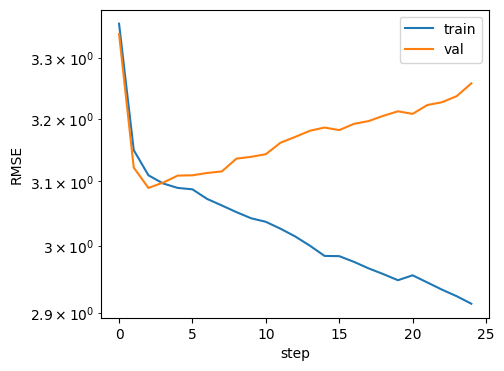

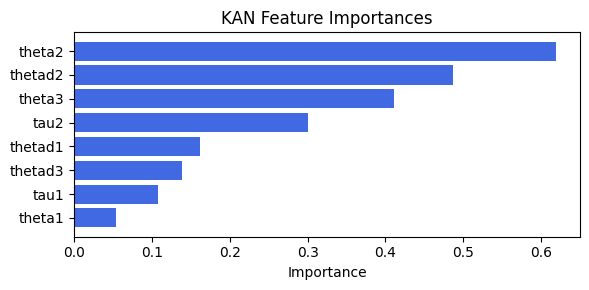

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.16it/s]

[('thetad2', 0.4535245426256145), ('thetad1', 0.43949790919552634), ('theta1', 0.40800665913515083), ('theta2', 0.33269379669173044), ('tau2', 0.3292939996299882), ('tau1', 0.3010204294754427), ('theta3', 0.15074126246588984), ('thetad3', 0.14167368163132127), ('Ex1', 0.14040523814654501)]


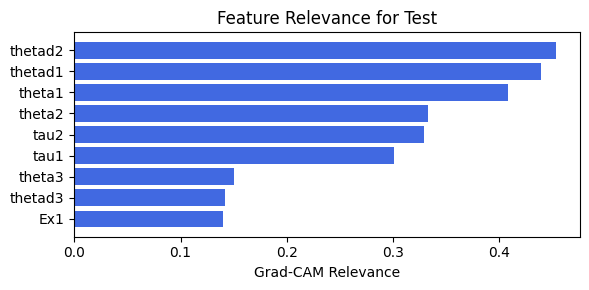

In [97]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.0.4. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.92e+00 | eval_loss: 3.26e+00 | reg: 3.32e+02 |: 100%|█| 25/25 [01:48<00:00,  4.33s/i

saving model version 0.1
Best epoch 2
3.227825164794922
M_KAN Relevance: 0.026475727558135986
CNN Relevance: 0.973524272441864
[('theta2', 0.6250147), ('thetad2', 0.47816056), ('theta3', 0.4112355), ('tau2', 0.3009338), ('thetad1', 0.16267037), ('thetad3', 0.1400964), ('tau1', 0.10615419), ('theta1', 0.0543669)]


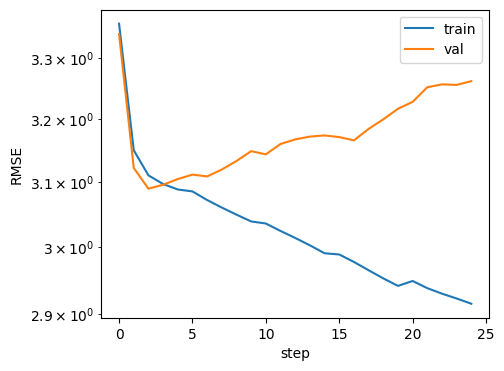

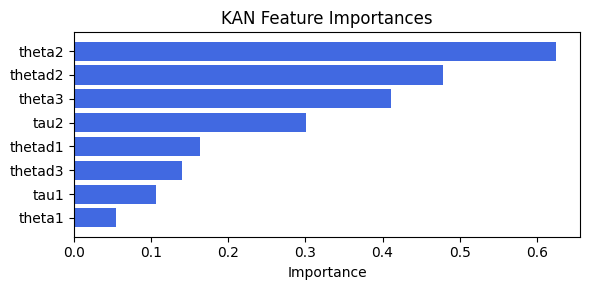

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:05<00:00, 13.03it/s]

[('thetad2', 0.4480817939528353), ('thetad1', 0.43656014923364733), ('theta1', 0.40462538541731885), ('theta2', 0.3324160718017336), ('tau2', 0.3209079522359939), ('tau1', 0.29414259081290817), ('theta3', 0.14493552922491415), ('Ex1', 0.1382480126219194), ('thetad3', 0.131415088526538)]


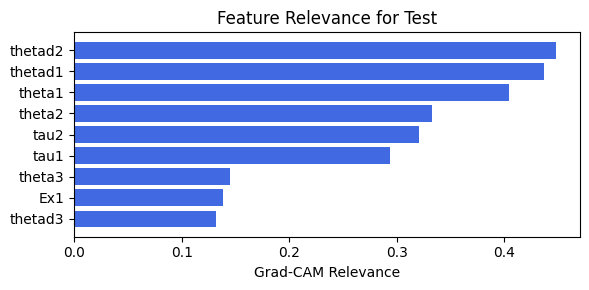

In [98]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.0.5. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.94e+00 | eval_loss: 3.23e+00 | reg: 3.51e+02 |: 100%|█| 25/25 [01:49<00:00,  4.38s/i

saving model version 0.1
Best epoch 6
3.2435073852539062
M_KAN Relevance: 0.043471042066812515
CNN Relevance: 0.9565289616584778
[('theta2', 0.70297396), ('thetad2', 0.4680792), ('theta3', 0.28156292), ('tau2', 0.27275875), ('thetad3', 0.17172281), ('thetad1', 0.14654899), ('tau1', 0.1131722), ('theta1', 0.092603356)]


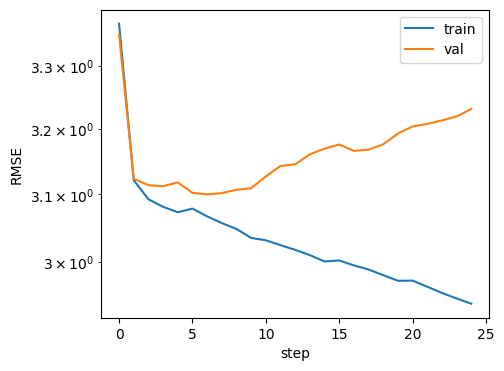

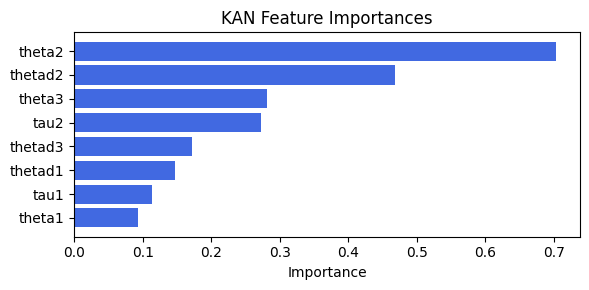

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:03<00:00, 13.31it/s]

[('tau1', 0.3764345117907075), ('tau2', 0.37617692766682564), ('thetad1', 0.25075276017629683), ('theta1', 0.24974626401297464), ('theta2', 0.16665416280637682), ('Ex1', 0.16351280082885142), ('thetad2', 0.14462627394128724), ('theta3', 0.14301900080383897), ('thetad3', 0.13232973761332154)]


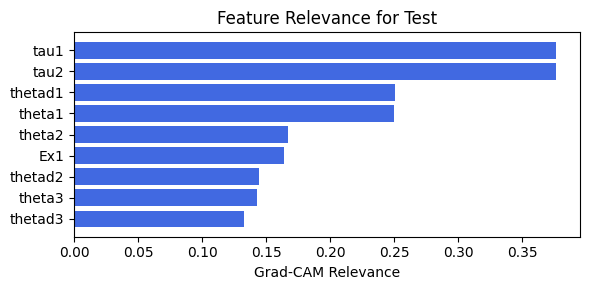

In [99]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.0.6. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.94e+00 | eval_loss: 3.23e+00 | reg: 3.45e+02 |: 100%|█| 25/25 [01:50<00:00,  4.40s/i

saving model version 0.1
Best epoch 6
3.2431914806365967
M_KAN Relevance: 0.04087759926915169
CNN Relevance: 0.9591224193572998
[('theta2', 0.6586545), ('thetad2', 0.48334587), ('theta3', 0.3591432), ('tau2', 0.28155375), ('thetad3', 0.18903777), ('tau1', 0.12553564), ('thetad1', 0.11448036), ('theta1', 0.10998635)]


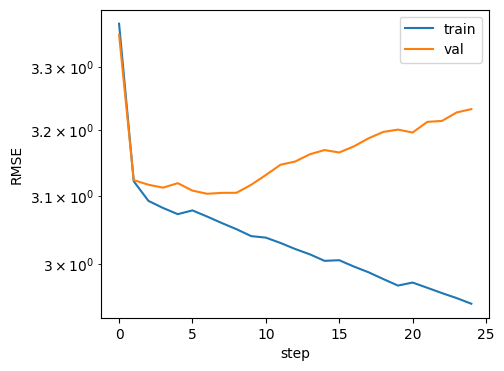

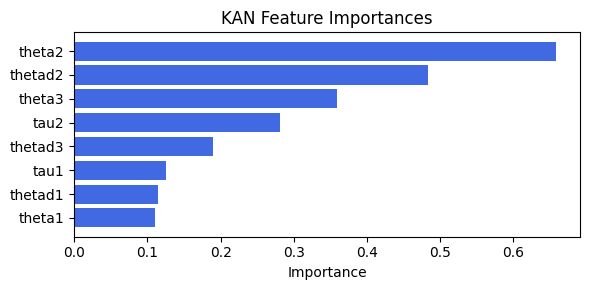

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.19it/s]

[('tau1', 0.3618430751150606), ('tau2', 0.35747772716161746), ('thetad1', 0.22818507820162115), ('theta1', 0.22677167634497955), ('Ex1', 0.15487968936948435), ('theta2', 0.13751856076444174), ('theta3', 0.13286223185391777), ('thetad2', 0.12470152230214662), ('thetad3', 0.10977000196351842)]


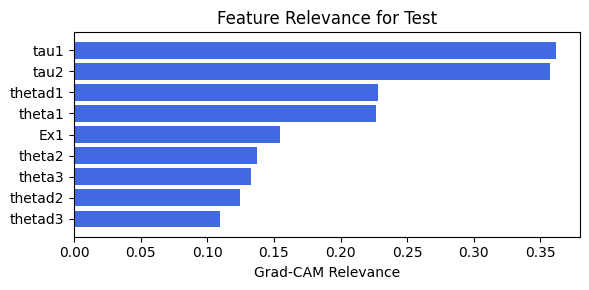

In [100]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.0.7. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.00e+00 | eval_loss: 3.18e+00 | reg: 2.81e+02 |: 100%|█| 25/25 [01:52<00:00,  4.50s/i

saving model version 0.1
Best epoch 4
3.234651803970337
M_KAN Relevance: 0.07564137130975723
CNN Relevance: 0.9243586659431458
[('theta2', 0.48802486), ('theta3', 0.46409452), ('thetad2', 0.32751086), ('tau2', 0.2753645), ('thetad1', 0.14217016), ('thetad3', 0.12907678), ('tau1', 0.087975726), ('theta1', 0.059383854)]


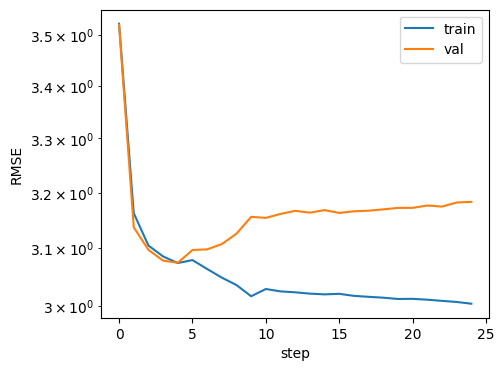

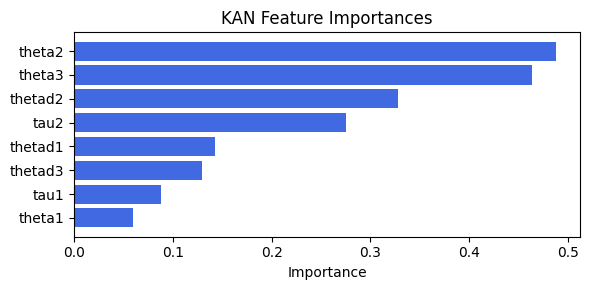

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:03<00:00, 13.27it/s]


[('tau1', 0.33223500093569125), ('tau2', 0.32257373389342836), ('thetad1', 0.29353187115481155), ('theta1', 0.29092848300351404), ('theta2', 0.2395112569436452), ('theta3', 0.2320349195251432), ('thetad2', 0.22287525108567502), ('Ex1', 0.21462941846118272), ('thetad3', 0.21094854574269745)]


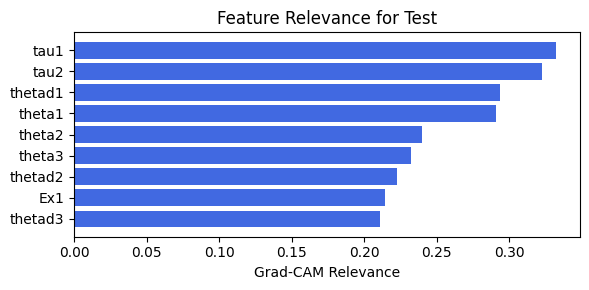

In [101]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.0.8. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.28e+00 | reg: 5.64e+02 |: 100%|█| 25/25 [01:46<00:00,  4.28s/i

saving model version 0.1
Best epoch 3
3.237623929977417
M_KAN Relevance: 0.08125294744968414
CNN Relevance: 0.918747067451477
[('theta2', 0.50090384), ('theta3', 0.44406232), ('thetad2', 0.3070457), ('tau2', 0.2739116), ('thetad1', 0.13846956), ('thetad3', 0.12864658), ('tau1', 0.093279816), ('theta1', 0.06147141)]


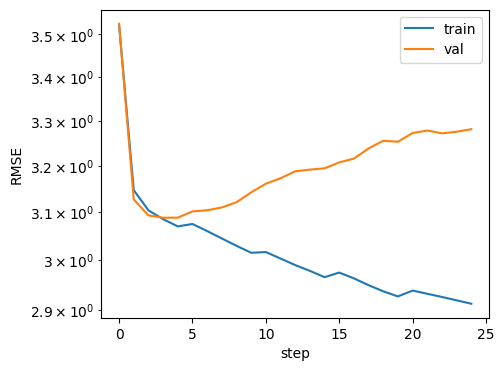

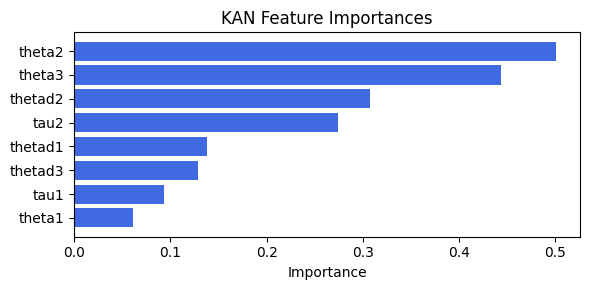

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.17it/s]

[('tau2', 0.29386826497659896), ('thetad3', 0.2841495921167247), ('tau1', 0.28053543934913183), ('thetad2', 0.28011257782103793), ('thetad1', 0.2744344862157565), ('Ex1', 0.27360772946622175), ('theta1', 0.2541399053335937), ('theta2', 0.2415608007919604), ('theta3', 0.23914144847397611)]


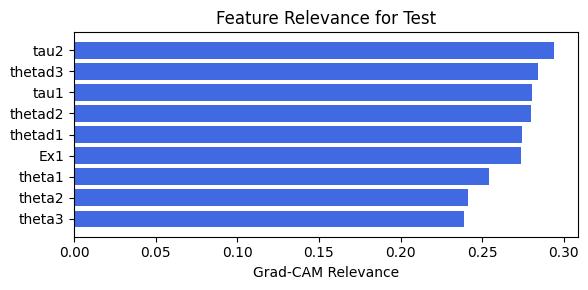

In [102]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.1.1. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.83e+00 | eval_loss: 3.36e+00 | reg: 3.17e+02 |: 100%|█| 25/25 [03:47<00:00,  9.09s/i

saving model version 0.1
Best epoch 8
3.239015579223633
M_KAN Relevance: 0.007248145993798971
CNN Relevance: 0.9927518367767334
[('thetad2', 0.57200956), ('theta2', 0.35534978), ('thetad1', 0.30725634), ('tau1', 0.30334032), ('thetad3', 0.27418357), ('theta3', 0.23557913), ('tau2', 0.21018879), ('theta1', 0.18781428)]


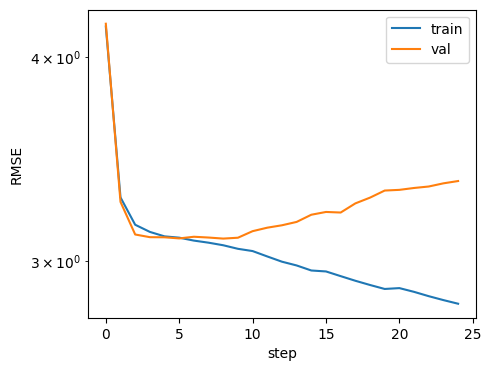

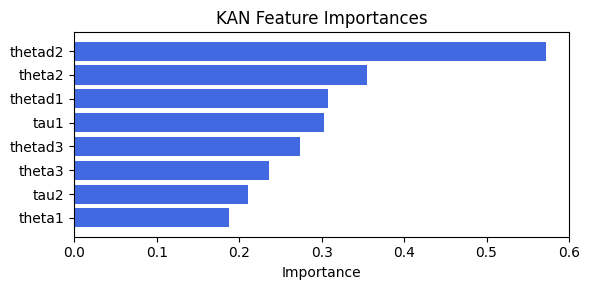

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:16<00:00, 11.98it/s]

[('theta1', 0.40455561981333593), ('thetad1', 0.36086956000686216), ('thetad2', 0.30596786033234086), ('tau1', 0.3054914252065853), ('theta2', 0.2626517465245317), ('tau2', 0.24342294409682877), ('theta3', 0.18747411988584375), ('thetad3', 0.11625839351640704), ('Ex1', 0.09879736643955009)]


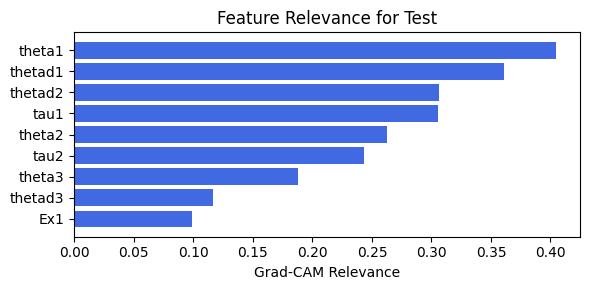

In [103]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.1.2. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.81e+00 | eval_loss: 3.32e+00 | reg: 3.14e+02 |: 100%|█| 25/25 [01:50<00:00,  4.42s/i

saving model version 0.1
Best epoch 8
3.2440621852874756
M_KAN Relevance: 0.006934215780347586
CNN Relevance: 0.9930657744407654
[('thetad2', 0.54427576), ('theta2', 0.35670134), ('tau1', 0.31870908), ('thetad1', 0.27870733), ('thetad3', 0.26444694), ('tau2', 0.24788098), ('theta3', 0.24644539), ('theta1', 0.22662842)]


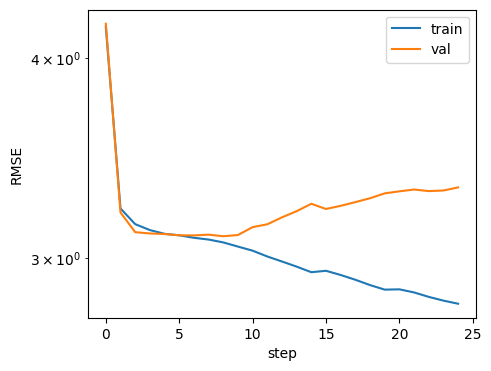

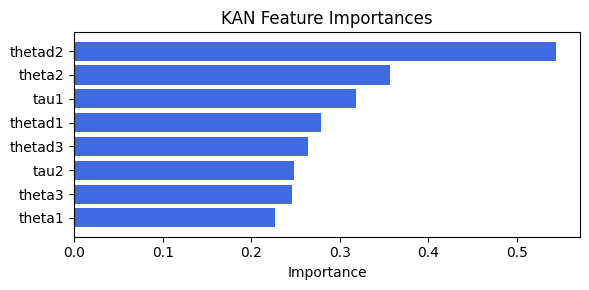

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:38<00:00, 10.35it/s]

[('theta1', 0.39214155001252154), ('thetad1', 0.3337935684441447), ('tau1', 0.29923549549437456), ('thetad2', 0.27750502256164616), ('theta2', 0.2572491214044683), ('theta3', 0.23958141513769973), ('tau2', 0.22901621197669667), ('thetad3', 0.17307294664506434), ('Ex1', 0.08850963220356456)]


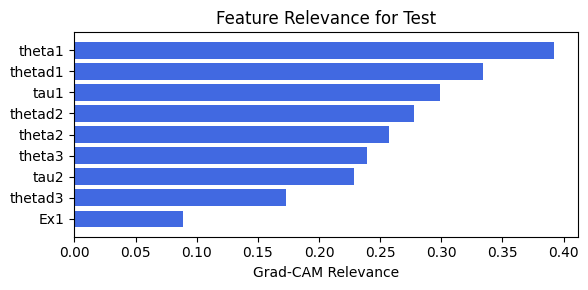

In [104]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.1.3. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.84e+00 | eval_loss: 3.29e+00 | reg: 3.22e+02 |: 100%|█| 25/25 [01:53<00:00,  4.55s/i

saving model version 0.1
Best epoch 7
3.2514939308166504
M_KAN Relevance: 0.0149410804733634
CNN Relevance: 0.9850589036941528
[('thetad2', 0.6347921), ('theta2', 0.34038186), ('thetad1', 0.3076474), ('theta3', 0.26856422), ('tau1', 0.2555501), ('thetad3', 0.21919124), ('tau2', 0.14813326), ('theta1', 0.09366202)]


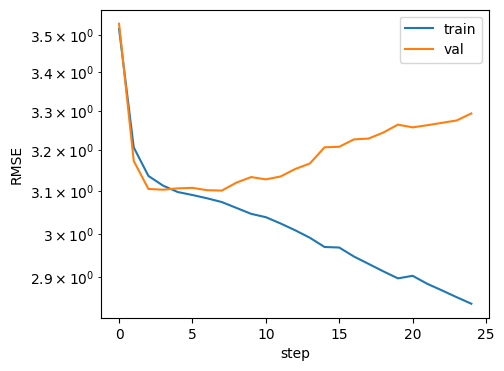

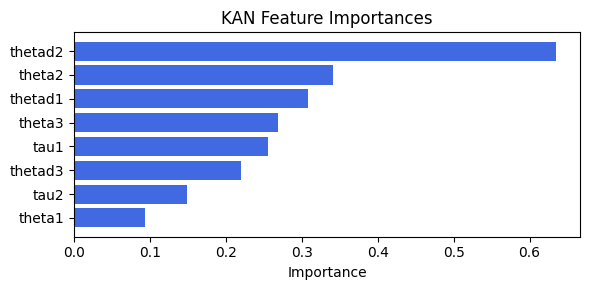

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:15<00:00, 12.08it/s]


[('theta1', 0.3454531919031057), ('thetad2', 0.28081134878503033), ('thetad1', 0.2751817639623327), ('theta2', 0.2746200589197469), ('Ex1', 0.22906091647326482), ('theta3', 0.2281786298776288), ('tau1', 0.22167448809880666), ('tau2', 0.1492941978744203), ('thetad3', 0.11092365090666129)]


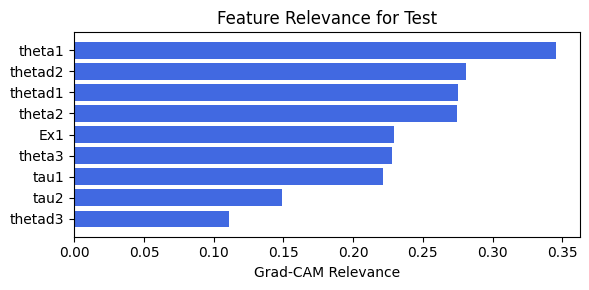

In [105]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.1.4. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.88e+00 | eval_loss: 3.28e+00 | reg: 3.03e+02 |: 100%|█| 25/25 [01:59<00:00,  4.76s/i

saving model version 0.1
Best epoch 6
3.257786273956299
M_KAN Relevance: 0.009955999441444874
CNN Relevance: 0.9900440573692322
[('thetad2', 0.58169365), ('theta2', 0.34494776), ('thetad1', 0.31905347), ('theta3', 0.31452858), ('thetad3', 0.2517271), ('tau1', 0.24500188), ('tau2', 0.15943962), ('theta1', 0.13292557)]


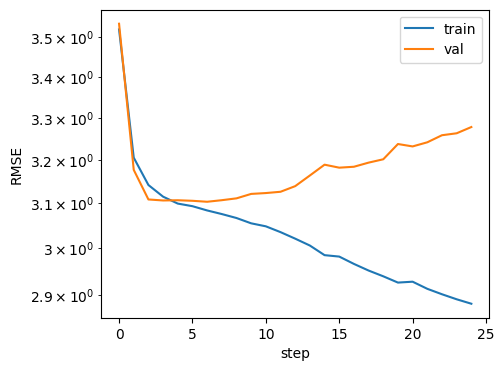

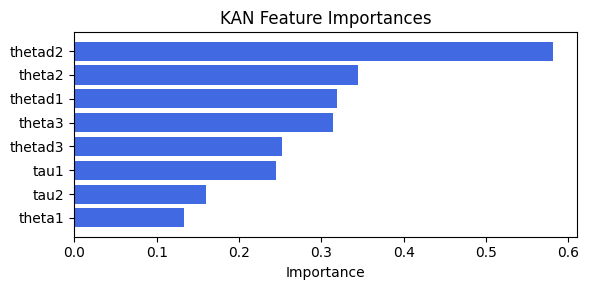

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.31it/s]

[('theta1', 0.3837397213637409), ('thetad1', 0.3250420459612933), ('theta2', 0.3056322062754604), ('thetad2', 0.29910579931759884), ('tau1', 0.2924071224336421), ('theta3', 0.25014166722774295), ('tau2', 0.20898338754133924), ('Ex1', 0.18610390852013078), ('thetad3', 0.11534173190294868)]


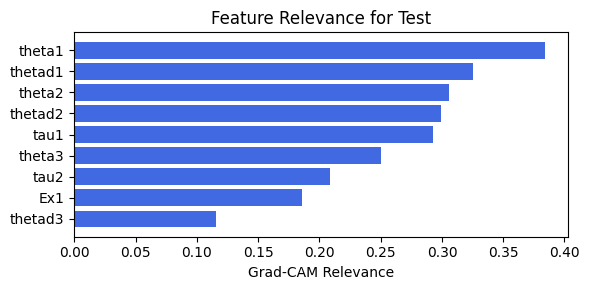

In [106]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.1.5. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.85e+00 | eval_loss: 3.31e+00 | reg: 3.79e+02 |: 100%|█| 25/25 [03:29<00:00,  8.40s/i

saving model version 0.1
Best epoch 5
3.240649938583374
M_KAN Relevance: 0.015287300571799278
CNN Relevance: 0.9847126603126526
[('theta3', 0.52693415), ('thetad2', 0.46138555), ('thetad1', 0.28664574), ('tau2', 0.260655), ('theta2', 0.24914084), ('tau1', 0.22817324), ('theta1', 0.13824616), ('thetad3', 0.10596034)]


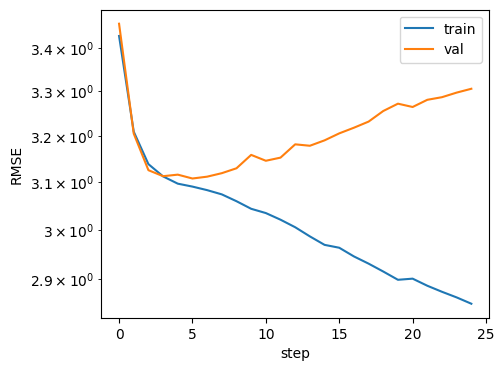

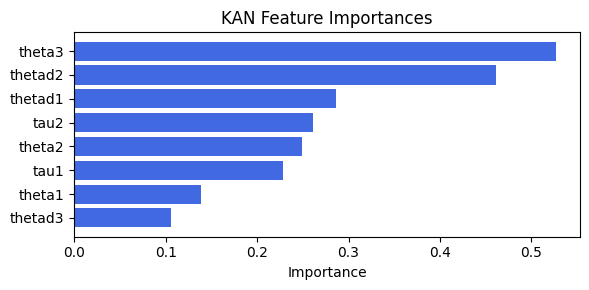

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.31it/s]

[('thetad1', 0.39995540561957954), ('tau2', 0.38907873609155497), ('tau1', 0.375634374257478), ('theta1', 0.3734214699779119), ('thetad2', 0.2839977962082262), ('theta2', 0.2601065788645487), ('thetad3', 0.15687311197580062), ('theta3', 0.15681922959173686), ('Ex1', 0.09961706706210115)]


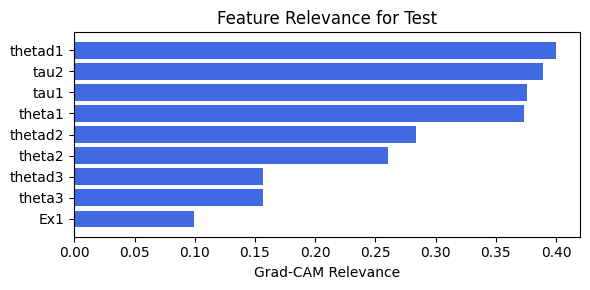

In [107]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.1.6. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.87e+00 | eval_loss: 3.27e+00 | reg: 3.68e+02 |: 100%|█| 25/25 [03:30<00:00,  8.41s/i


saving model version 0.1
Best epoch 5
3.2426304817199707
M_KAN Relevance: 0.015973199158906937
CNN Relevance: 0.9840268492698669
[('theta3', 0.52081716), ('thetad2', 0.47077116), ('thetad1', 0.28656963), ('tau2', 0.25236663), ('theta2', 0.22820908), ('tau1', 0.22394282), ('theta1', 0.14096457), ('thetad3', 0.11198355)]


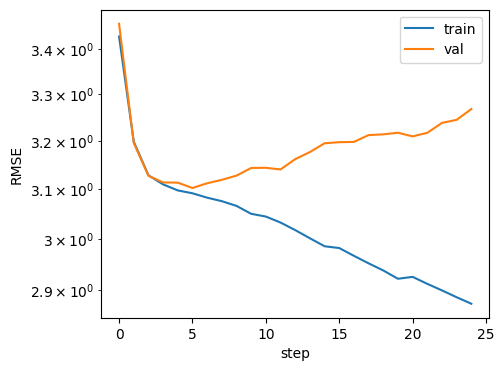

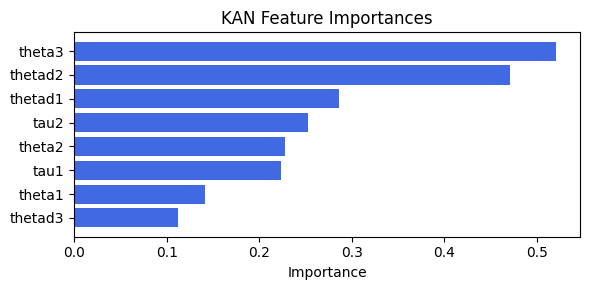

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.25it/s]

[('thetad1', 0.41731715938653124), ('tau2', 0.4040456706443287), ('tau1', 0.39521870422127653), ('theta1', 0.39452430860586835), ('thetad2', 0.28944609042885955), ('theta2', 0.2738918013073921), ('theta3', 0.17170581408669613), ('thetad3', 0.14750009737825737), ('Ex1', 0.10169988950990094)]


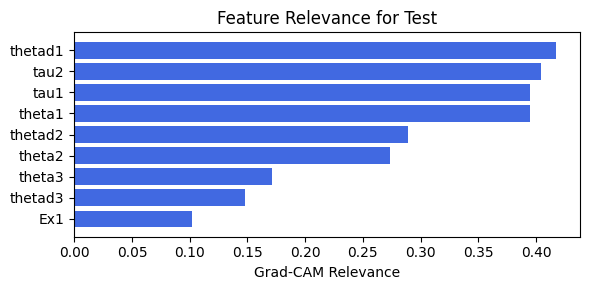

In [108]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.1.7. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.82e+00 | eval_loss: 3.39e+00 | reg: 3.46e+02 |: 100%|█| 25/25 [01:58<00:00,  4.73s/i

saving model version 0.1
Best epoch 3
3.2278313636779785
M_KAN Relevance: 0.007292215246707201
CNN Relevance: 0.9927077889442444
[('theta2', 0.685734), ('theta3', 0.51375526), ('thetad2', 0.35379928), ('tau2', 0.18865627), ('thetad3', 0.15781395), ('theta1', 0.13097325), ('thetad1', 0.095811605), ('tau1', 0.04143474)]


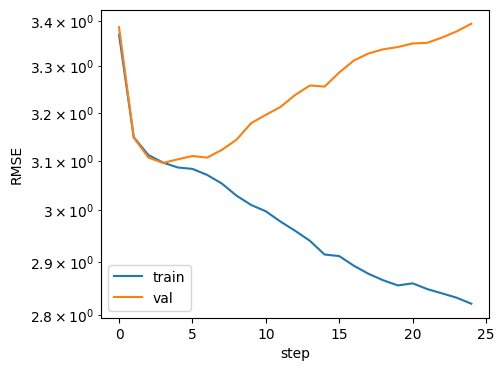

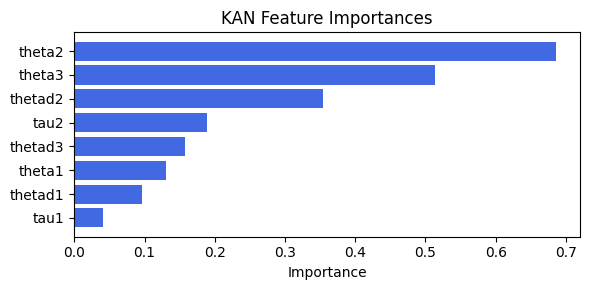

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.34it/s]

[('Ex1', 0.43862922961537115), ('tau1', 0.4176380355652538), ('tau2', 0.37962286066229606), ('theta1', 0.37517623662894056), ('thetad1', 0.3727074173629844), ('thetad2', 0.340777081599673), ('theta2', 0.2876143512578356), ('theta3', 0.22229882039010335), ('thetad3', 0.141472387627049)]


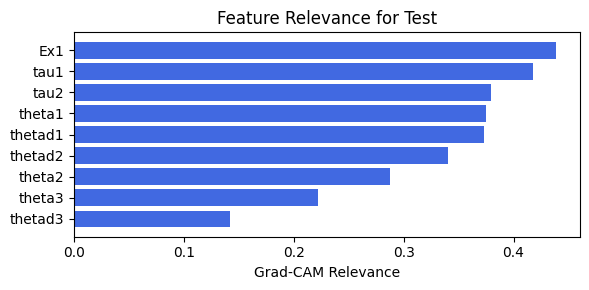

In [109]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.1.8. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.79e+00 | eval_loss: 3.42e+00 | reg: 3.72e+02 |: 100%|█| 25/25 [01:59<00:00,  4.78s/i

saving model version 0.1
Best epoch 4
3.230664014816284
M_KAN Relevance: 0.008922073990106583
CNN Relevance: 0.9910779595375061
[('theta2', 0.67333716), ('theta3', 0.49317038), ('thetad2', 0.3845621), ('thetad3', 0.18028927), ('tau2', 0.17795102), ('theta1', 0.1265957), ('thetad1', 0.109087944), ('tau1', 0.055369716)]


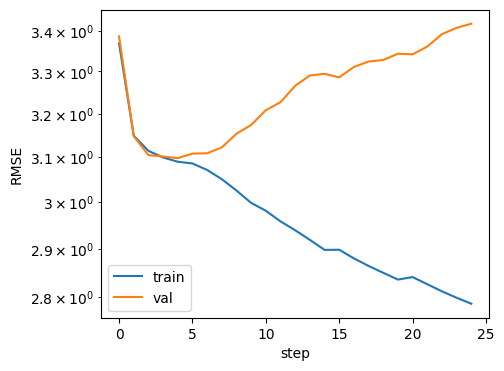

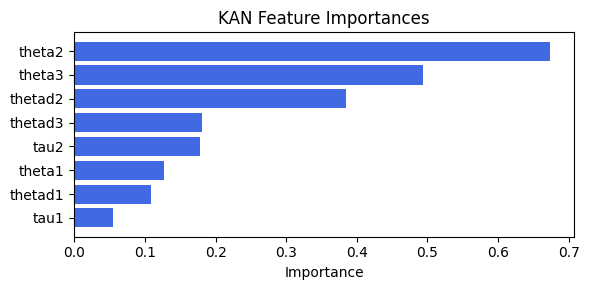

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:11<00:00, 12.46it/s]

[('Ex1', 0.44958066179928763), ('tau1', 0.4244197666250275), ('tau2', 0.3868241329656485), ('theta1', 0.3719400819886523), ('thetad1', 0.37146209658896445), ('thetad2', 0.3265861186901342), ('theta2', 0.2949908877253742), ('theta3', 0.2304042485573839), ('thetad3', 0.1591193428368956)]


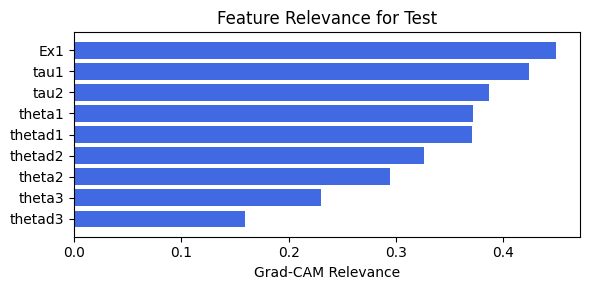

In [110]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.2.0 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.08e+01 |: 100%|█| 25/25 [01:30<00:00,  3.63s/i

saving model version 0.1
Best epoch 13
3.2272720336914062
M_KAN Relevance: 0.19425958395004272
CNN Relevance: 0.8057404160499573
[('theta2', 0.4313428), ('tau2', 0.30888534), ('theta1', 0.30055153), ('thetad2', 0.25684184), ('theta3', 0.20753604), ('thetad3', 0.18316248), ('tau1', 0.15173542), ('thetad1', 0.14196053)]


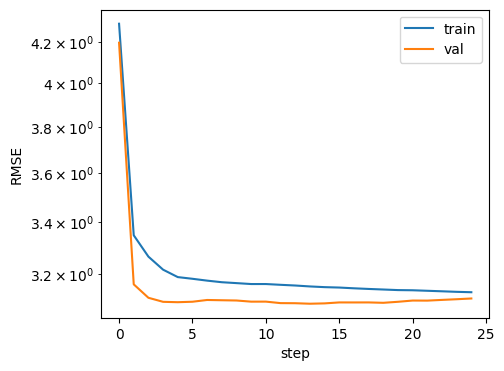

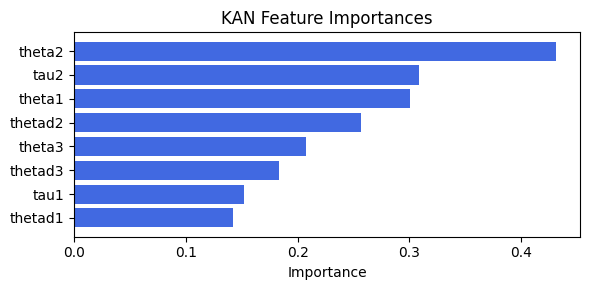

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:14<00:00, 12.17it/s]

[('tau1', 0.3832703952426126), ('tau2', 0.3586009667489191), ('thetad1', 0.3273718048929089), ('theta1', 0.3210252123563134), ('thetad2', 0.21599665933454557), ('theta2', 0.2133534609073471), ('Ex1', 0.15789774399089654), ('theta3', 0.1407738235779142), ('thetad3', 0.13936977704183182)]


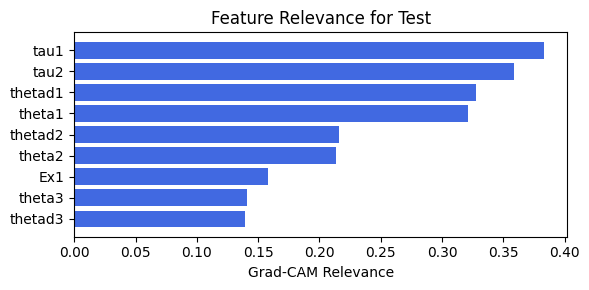

In [111]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.2.1 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.26e+01 |: 100%|█| 25/25 [01:28<00:00,  3.54s/i

saving model version 0.1
Best epoch 11
3.2292561531066895
M_KAN Relevance: 0.1798151135444641
CNN Relevance: 0.8201849460601807
[('theta2', 0.37455052), ('tau1', 0.34980485), ('theta1', 0.2914654), ('tau2', 0.27357802), ('theta3', 0.2436842), ('thetad2', 0.24356675), ('thetad3', 0.20377162), ('thetad1', 0.08224998)]


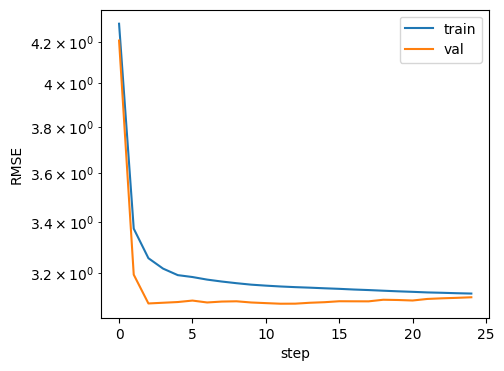

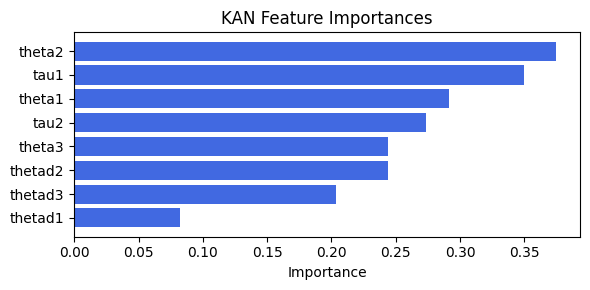

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.85it/s]

[('tau1', 0.3889554734079795), ('thetad1', 0.3610787703745156), ('theta1', 0.35752567876071534), ('tau2', 0.32824805418968606), ('thetad2', 0.25630214350664055), ('theta2', 0.2398760748300119), ('thetad3', 0.1740687804736917), ('theta3', 0.17262238558374374), ('Ex1', 0.07526329180270017)]


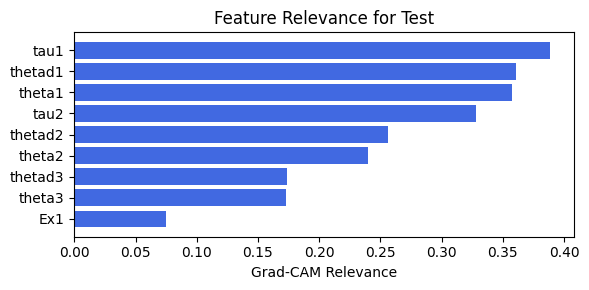

In [112]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.2.2 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.12e+00 | reg: 4.81e+01 |: 100%|█| 25/25 [01:31<00:00,  3.64s/i

saving model version 0.1
Best epoch 4
3.2285125255584717
M_KAN Relevance: 0.1439754068851471
CNN Relevance: 0.8560245633125305
[('theta2', 0.6033399), ('tau1', 0.249466), ('theta3', 0.24719688), ('thetad2', 0.2269239), ('thetad3', 0.18791553), ('thetad1', 0.166529), ('tau2', 0.097448274), ('theta1', 0.066283636)]


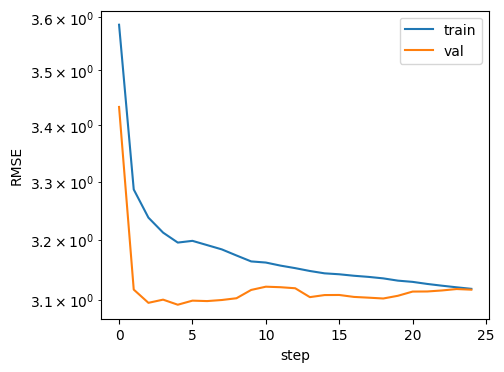

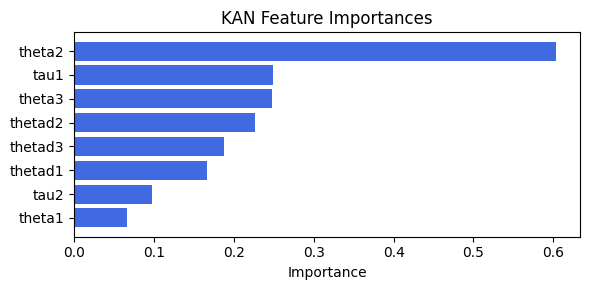

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:24<00:00, 11.32it/s]


[('tau1', 0.38426385009202474), ('tau2', 0.36293768613157035), ('theta1', 0.34915960717947997), ('thetad1', 0.342960862444023), ('theta2', 0.2658093791517926), ('thetad2', 0.2450227407775492), ('theta3', 0.21488197796801933), ('thetad3', 0.18727649377484126), ('Ex1', 0.14469307113909832)]


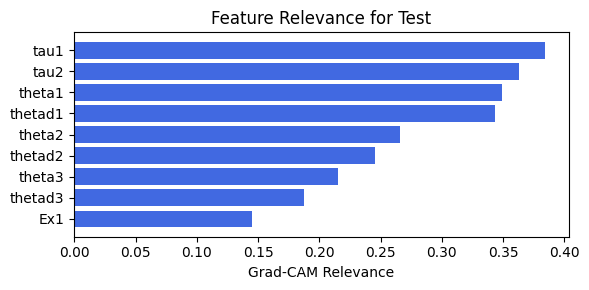

In [113]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.2.3 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.12e+00 | reg: 4.43e+01 |: 100%|█| 25/25 [01:31<00:00,  3.65s/i

saving model version 0.1
Best epoch 4
3.2260615825653076
M_KAN Relevance: 0.1433311402797699
CNN Relevance: 0.8566688299179077
[('theta2', 0.62863237), ('tau2', 0.26665688), ('thetad2', 0.24357834), ('thetad3', 0.22991529), ('tau1', 0.22255716), ('theta3', 0.1718848), ('thetad1', 0.1593746), ('theta1', 0.11775489)]


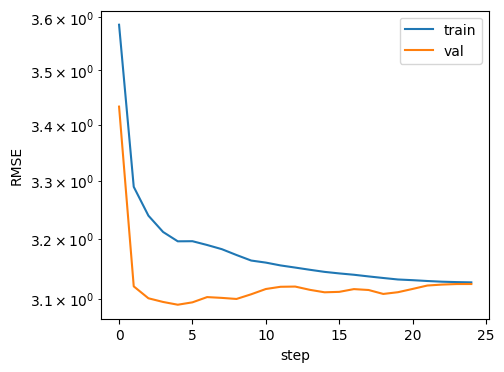

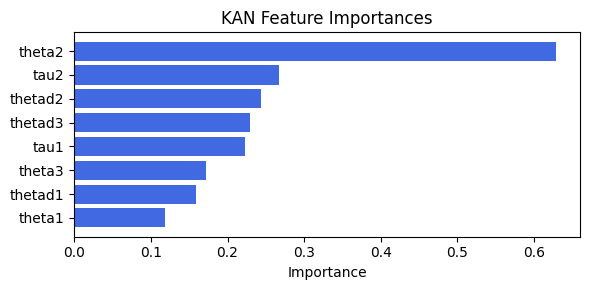

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.86it/s]


[('tau1', 0.3786305066414498), ('tau2', 0.357991691310836), ('theta1', 0.33812128866512997), ('thetad1', 0.33354477543281946), ('theta2', 0.25245774592401554), ('thetad2', 0.2396680184562432), ('theta3', 0.22202063428403646), ('thetad3', 0.19915561117506014), ('Ex1', 0.14385111315172766)]


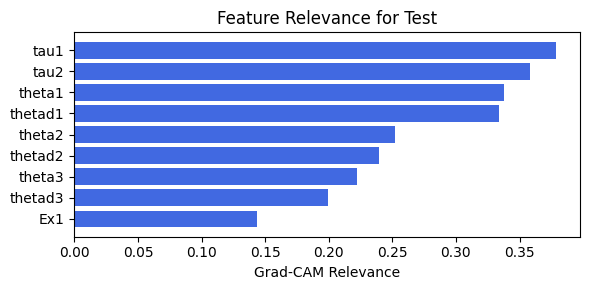

In [114]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.2.4. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.17e+01 |: 100%|█| 30/30 [01:45<00:00,  3.50s/i

saving model version 0.1
Best epoch 4
3.23386812210083
M_KAN Relevance: 0.17032037675380707
CNN Relevance: 0.8296796083450317
[('theta2', 0.7404524), ('theta3', 0.38729423), ('thetad2', 0.14263076), ('theta1', 0.09801082), ('thetad3', 0.0850772), ('tau1', 0.08065701), ('thetad1', 0.057849653), ('tau2', 0.048229158)]


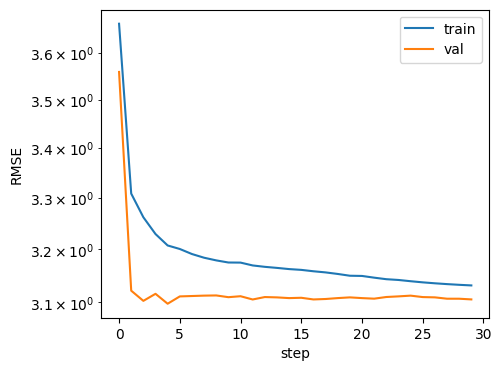

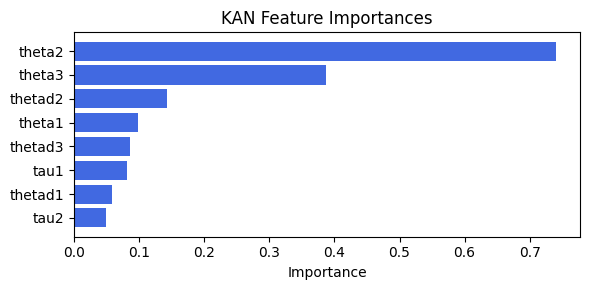

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:23<00:00, 11.40it/s]


[('tau1', 0.3952549328444249), ('theta1', 0.37442527539574083), ('tau2', 0.3677825137623444), ('thetad1', 0.3584487164009373), ('theta2', 0.2686510264633323), ('thetad2', 0.26265759809381134), ('theta3', 0.2364506671984201), ('Ex1', 0.21426305792365488), ('thetad3', 0.1876045535970149)]


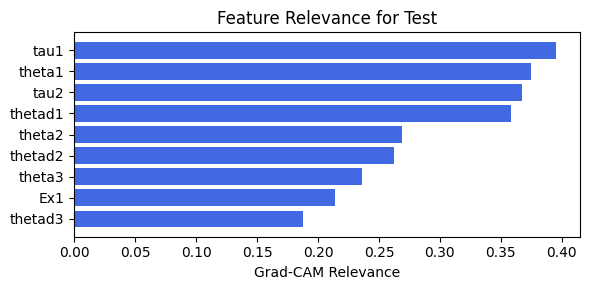

In [115]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=30, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.2.5. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.11e+00 | reg: 4.50e+01 |: 100%|█| 30/30 [01:44<00:00,  3.49s/i

saving model version 0.1
Best epoch 4
3.2385170459747314
M_KAN Relevance: 0.15520323812961578
CNN Relevance: 0.8447967767715454
[('theta2', 0.7344291), ('theta3', 0.38671824), ('thetad1', 0.13058195), ('tau2', 0.10660827), ('thetad3', 0.081131816), ('thetad2', 0.078607365), ('theta1', 0.076664515), ('tau1', 0.053437136)]


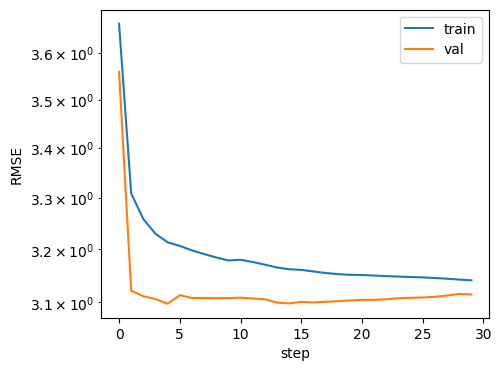

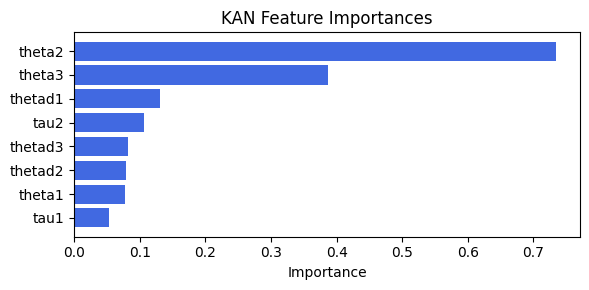

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.55it/s]

[('tau1', 0.3963198165370628), ('theta1', 0.38253828570053644), ('thetad1', 0.362358211455464), ('tau2', 0.3606505898648391), ('theta2', 0.2758128823291354), ('thetad2', 0.25576553887277365), ('theta3', 0.2288645697760656), ('Ex1', 0.19461141908720136), ('thetad3', 0.18985924805077903)]


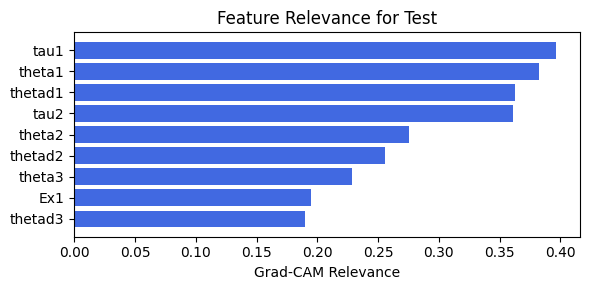

In [116]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=30, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.2.6. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.11e+00 | reg: 3.18e+01 |: 100%|█| 25/25 [01:29<00:00,  3.59s/i

saving model version 0.1
Best epoch 7
3.2407612800598145
M_KAN Relevance: 0.8009408712387085
CNN Relevance: 0.19905906915664673
[('theta2', 0.5027044), ('theta3', 0.48227513), ('thetad1', 0.19076204), ('tau2', 0.15953152), ('thetad2', 0.10418168), ('tau1', 0.07620709), ('thetad3', 0.075268), ('theta1', 0.0628665)]


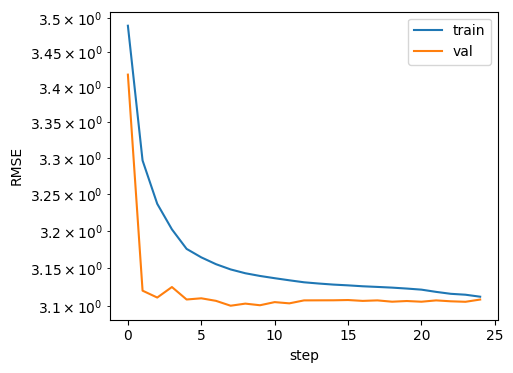

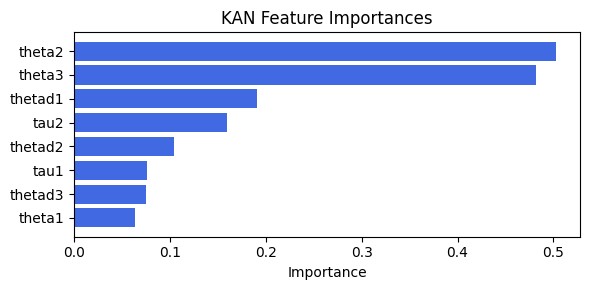

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:22<00:00, 11.49it/s]

[('theta1', 0.27949877256173683), ('thetad1', 0.27035585151298586), ('thetad2', 0.2580355886132939), ('theta2', 0.24121715312012973), ('tau1', 0.23494759509712115), ('tau2', 0.23211277472579683), ('theta3', 0.17373610051380625), ('thetad3', 0.16339169059047767), ('Ex1', 0.14490237472907885)]


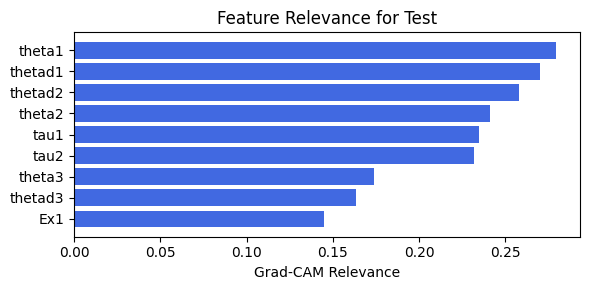

In [117]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.2.7. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 3.00e+01 |: 100%|█| 25/25 [01:30<00:00,  3.63s/i

saving model version 0.1
Best epoch 12
3.2445900440216064
M_KAN Relevance: 0.8488758206367493
CNN Relevance: 0.15112417936325073
[('theta2', 0.6190947), ('theta3', 0.4625332), ('thetad1', 0.17379847), ('thetad2', 0.15766573), ('thetad3', 0.14160515), ('tau1', 0.11765233), ('theta1', 0.0982526), ('tau2', 0.030524746)]


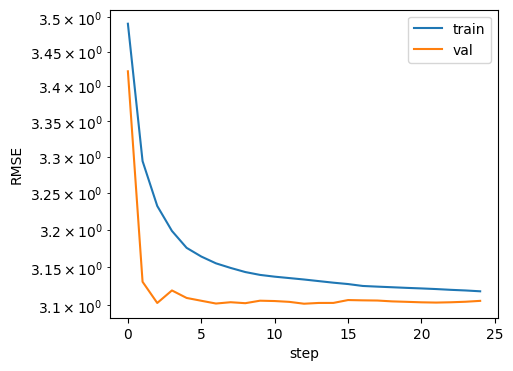

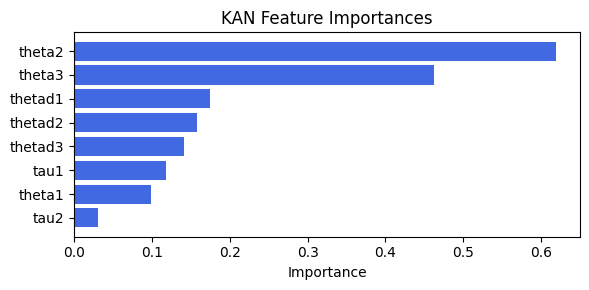

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:30<00:00, 10.87it/s]

[('thetad3', 0.221409565878838), ('theta1', 0.21374720191742708), ('thetad1', 0.2081549035550232), ('tau1', 0.19899355708845004), ('tau2', 0.19603670855122945), ('theta2', 0.19191711770799064), ('thetad2', 0.18509403581799846), ('theta3', 0.17122286582011192), ('Ex1', 0.1603797293799249)]


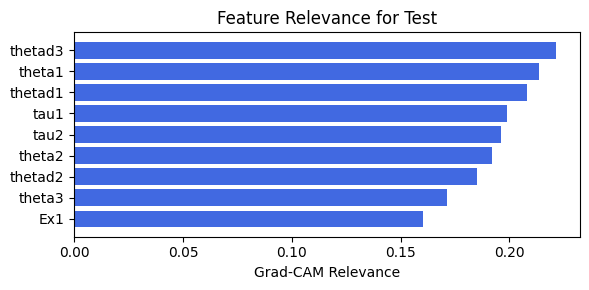

In [118]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.3.1. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.15e+00 | reg: 6.77e+01 |: 100%|█| 25/25 [01:59<00:00,  4.78s/i

saving model version 0.1
Best epoch 8
3.2297446727752686
M_KAN Relevance: 0.004839085973799229
CNN Relevance: 0.9951609373092651
[('tau2', 0.55165255), ('thetad2', 0.5053901), ('theta1', 0.23416726), ('theta3', 0.22944924), ('thetad1', 0.18867329), ('tau1', 0.11860256), ('theta2', 0.07923144), ('thetad3', 0.07175192)]


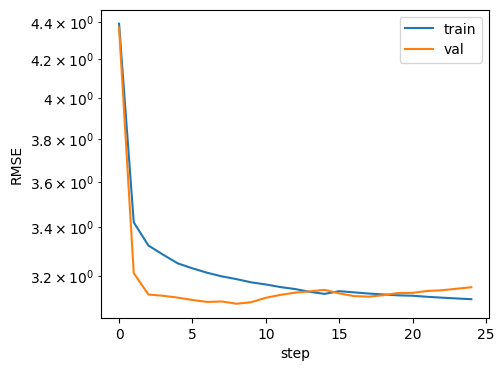

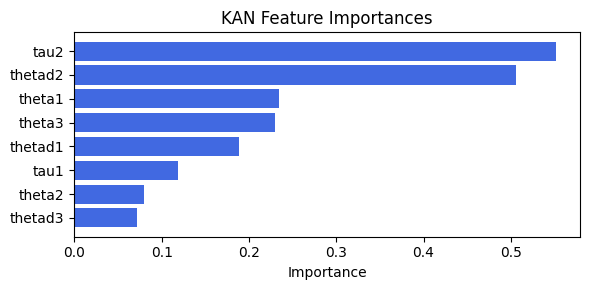

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.61it/s]

[('tau1', 0.45611056358111285), ('tau2', 0.3883860256806687), ('theta1', 0.37563442742799213), ('thetad1', 0.36298630184444525), ('Ex1', 0.28809798801518965), ('thetad2', 0.27992339569820834), ('theta2', 0.2680284408314841), ('theta3', 0.2596644197893922), ('thetad3', 0.17470681190027282)]


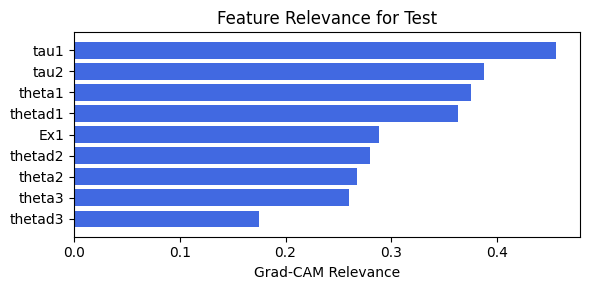

In [119]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.3.2. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.10e+00 | eval_loss: 3.17e+00 | reg: 7.24e+01 |: 100%|█| 25/25 [02:02<00:00,  4.89s/i


saving model version 0.1
Best epoch 7
3.2254140377044678
M_KAN Relevance: 0.00013785166083835065
CNN Relevance: 0.9998621344566345
[('theta3', 0.37536654), ('theta1', 0.3680277), ('thetad3', 0.35603154), ('tau1', 0.35009974), ('thetad2', 0.346762), ('tau2', 0.30086726), ('theta2', 0.29921365), ('thetad1', 0.19117624)]


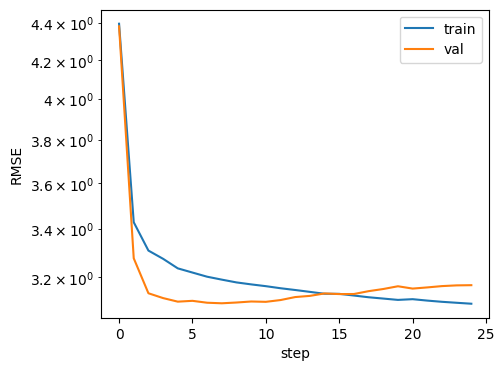

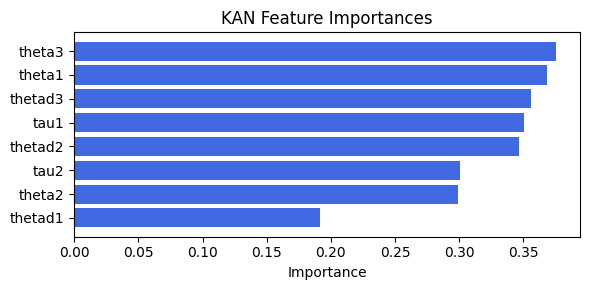

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:20<00:00, 11.65it/s]


[('tau1', 0.381413531177359), ('theta1', 0.3710195973861489), ('thetad1', 0.33046250048300474), ('thetad2', 0.29124240627177755), ('theta2', 0.27024418392329524), ('tau2', 0.2679347449083052), ('theta3', 0.2635687788634525), ('Ex1', 0.20988499616873327), ('thetad3', 0.1491527362051807)]


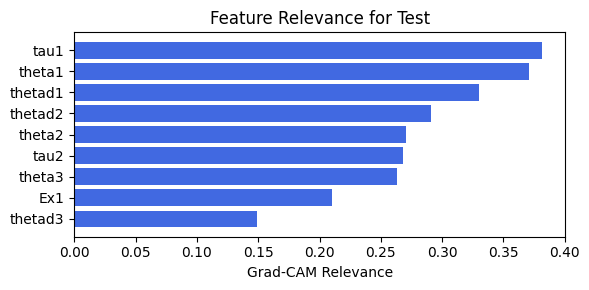

In [120]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.75, filename=filename_2, opt_col_val=0.75)

### 2.3.3. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.16e+00 | reg: 7.71e+01 |: 100%|█| 25/25 [01:51<00:00,  4.46s/i


saving model version 0.1
Best epoch 5
3.2296106815338135
M_KAN Relevance: 0.00437043234705925
CNN Relevance: 0.9956295490264893
[('thetad2', 0.5243551), ('theta3', 0.52006567), ('theta2', 0.22608326), ('thetad1', 0.1671167), ('thetad3', 0.14996287), ('theta1', 0.14818768), ('tau1', 0.12082693), ('tau2', 0.05120346)]


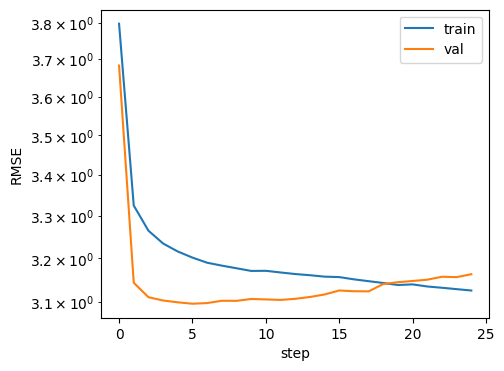

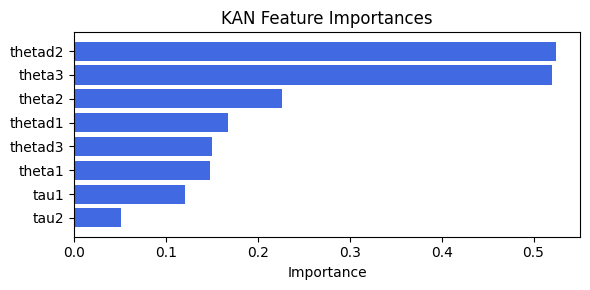

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:19<00:00, 11.78it/s]

[('tau1', 0.3455231422329716), ('theta1', 0.3358208808513876), ('tau2', 0.3354683910342526), ('thetad1', 0.32492531749244985), ('thetad2', 0.27508094322573184), ('theta2', 0.25060434101126694), ('theta3', 0.188212233483574), ('Ex1', 0.17189889883401202), ('thetad3', 0.1053339588217414)]


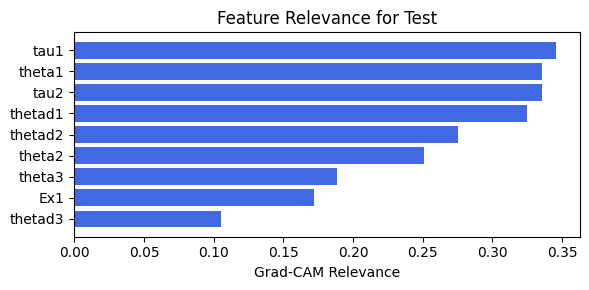

In [121]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.3.4. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.16e+00 | reg: 7.07e+01 |: 100%|█| 25/25 [01:49<00:00,  4.36s/i


saving model version 0.1
Best epoch 6
3.2244677543640137
M_KAN Relevance: 0.005490081384778023
CNN Relevance: 0.9945099353790283
[('thetad2', 0.43954536), ('theta1', 0.42628726), ('theta3', 0.30581486), ('theta2', 0.14444941), ('thetad1', 0.13591583), ('tau1', 0.13289528), ('tau2', 0.10214003), ('thetad3', 0.038145613)]


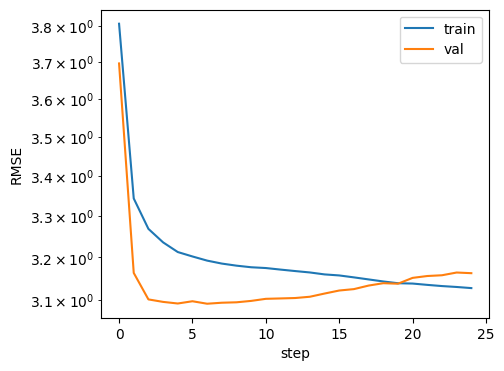

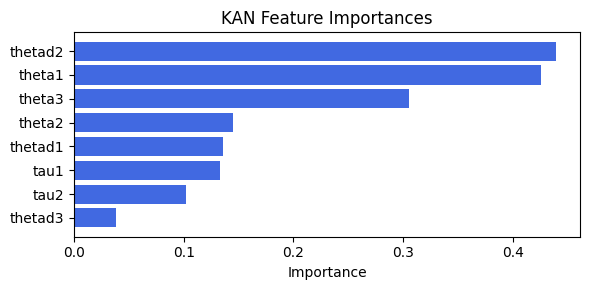

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:22<00:00, 11.48it/s]


[('theta1', 0.4001999175845253), ('thetad1', 0.3829453737367969), ('tau1', 0.3565071587861133), ('tau2', 0.33486260134574), ('thetad2', 0.3330514967513777), ('theta2', 0.29284044413397214), ('Ex1', 0.19169312780930556), ('theta3', 0.17642478068133008), ('thetad3', 0.10314251466933311)]


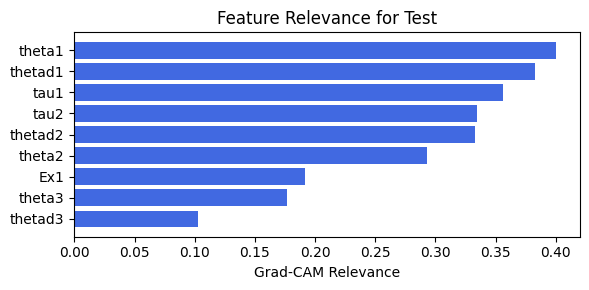

In [122]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.5, filename=filename_2, opt_col_val=0.5)

### 2.3.5. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.13e+00 | reg: 8.24e+01 |: 100%|█| 25/25 [01:49<00:00,  4.38s/i

saving model version 0.1
Best epoch 6
3.2377307415008545
M_KAN Relevance: 0.009984192438423634
CNN Relevance: 0.9900158643722534
[('thetad2', 0.7399142), ('theta1', 0.2542761), ('theta2', 0.24738327), ('thetad1', 0.24504727), ('thetad3', 0.23778832), ('theta3', 0.2239764), ('tau2', 0.13537589), ('tau1', 0.06694974)]


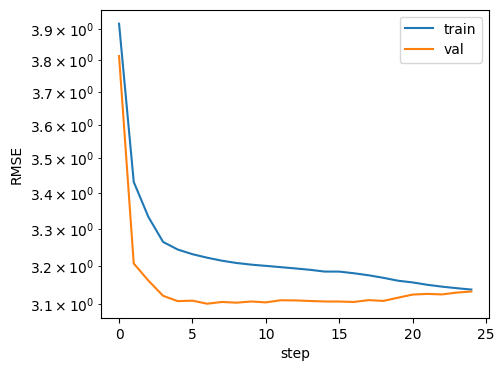

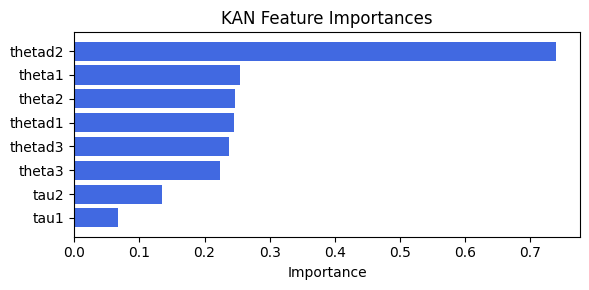

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.52it/s]

[('tau1', 0.4173501479758212), ('tau2', 0.390815899567115), ('thetad1', 0.3475329853759302), ('theta1', 0.33664468657519425), ('thetad2', 0.29066944851962934), ('theta2', 0.2594425279484351), ('theta3', 0.21525250158928966), ('Ex1', 0.21303622428416727), ('thetad3', 0.16374113801707665)]


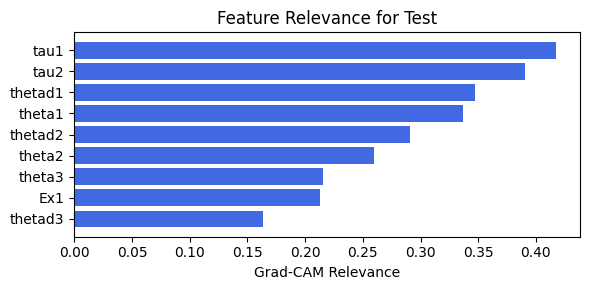

In [123]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.3.6. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.17e+00 | reg: 7.68e+01 |: 100%|█| 25/25 [01:48<00:00,  4.34s/i

saving model version 0.1
Best epoch 7
3.2341108322143555
M_KAN Relevance: 0.0194805059581995
CNN Relevance: 0.9805195331573486
[('thetad2', 0.6672489), ('theta1', 0.33817467), ('theta2', 0.2890196), ('thetad3', 0.19152908), ('thetad1', 0.11163089), ('theta3', 0.103048496), ('tau1', 0.06764204), ('tau2', 0.030876122)]


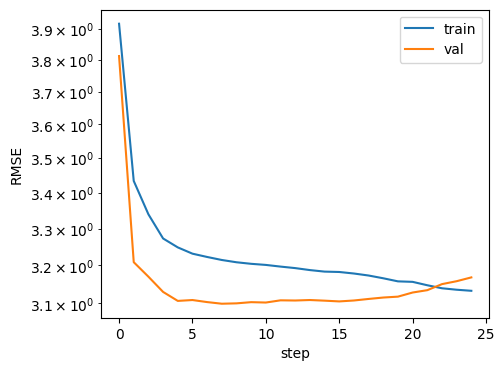

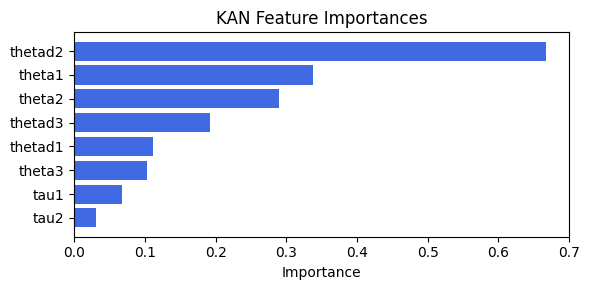

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:54<00:00, 14.29it/s]

[('tau1', 0.4220393777585147), ('tau2', 0.3834172880173851), ('thetad1', 0.3579831084409563), ('theta1', 0.35463848790890284), ('thetad2', 0.2891192414590955), ('theta2', 0.2614940494463223), ('theta3', 0.23957288305489755), ('thetad3', 0.22757669721287796), ('Ex1', 0.19346664424415574)]


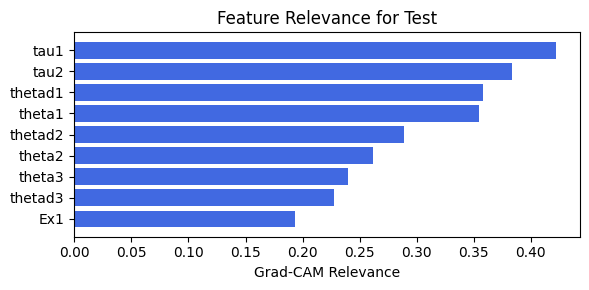

In [124]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.25, filename=filename_2, opt_col_val=0.25)

### 2.3.7. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.10e+00 | eval_loss: 3.20e+00 | reg: 7.75e+01 |: 100%|█| 25/25 [01:46<00:00,  4.25s/i

saving model version 0.1
Best epoch 4
3.2375760078430176
M_KAN Relevance: 0.02629312314093113
CNN Relevance: 0.9737069010734558
[('theta2', 0.74728155), ('thetad2', 0.55520236), ('theta3', 0.12293404), ('thetad1', 0.07899212), ('tau1', 0.056825347), ('tau2', 0.03055047), ('thetad3', 0.02556571), ('theta1', 0.021906689)]


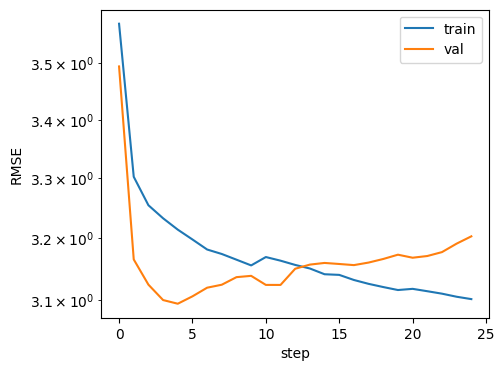

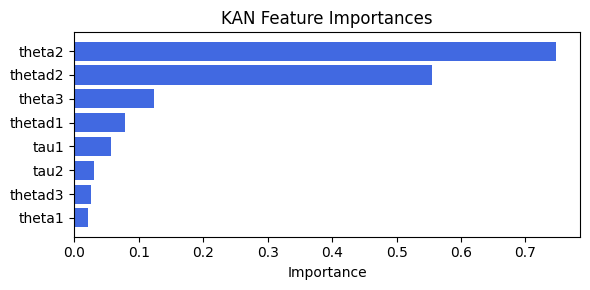

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:00<00:00, 13.65it/s]

[('tau2', 0.5015893633659475), ('tau1', 0.47128465503934075), ('thetad1', 0.3121531023842002), ('Ex1', 0.2978314140398995), ('theta1', 0.28943680596597265), ('theta3', 0.24085013160329766), ('thetad2', 0.22847031525402903), ('theta2', 0.2145325539522002), ('thetad3', 0.20544309631028396)]


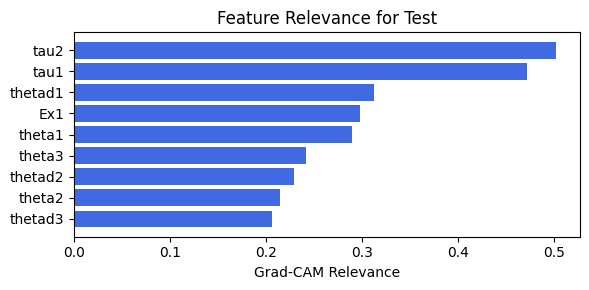

In [125]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

### 2.3.8. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.18e+00 | reg: 7.45e+01 |: 100%|█| 25/25 [01:46<00:00,  4.26s/i

saving model version 0.1
Best epoch 5
3.2446908950805664
M_KAN Relevance: 0.06367150694131851
CNN Relevance: 0.9363285303115845
[('theta2', 0.73813224), ('thetad2', 0.48541307), ('theta3', 0.17282781), ('theta1', 0.16309528), ('tau2', 0.098029695), ('thetad1', 0.09158911), ('thetad3', 0.08470993), ('tau1', 0.038814094)]


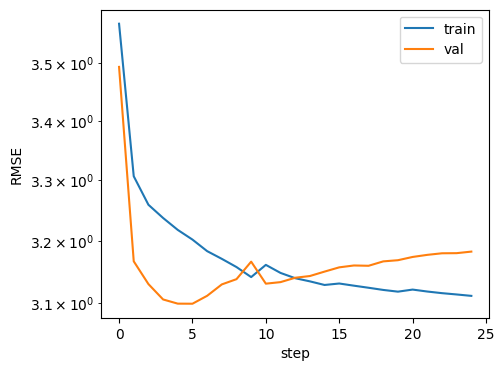

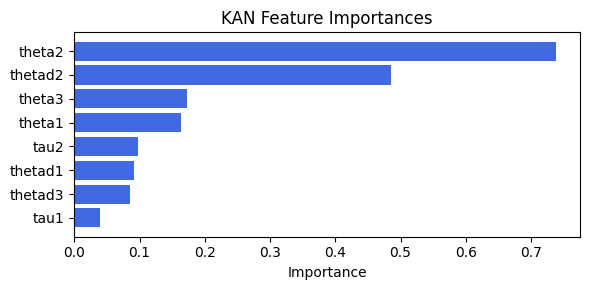

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:02<00:00, 13.38it/s]


[('tau2', 0.5024591054833435), ('tau1', 0.4723598131687701), ('thetad1', 0.31673246889287676), ('theta1', 0.287795093155114), ('Ex1', 0.27643914121299756), ('thetad3', 0.2557972517229126), ('theta3', 0.2511031895892718), ('thetad2', 0.22583581283967685), ('theta2', 0.2210348552284189)]


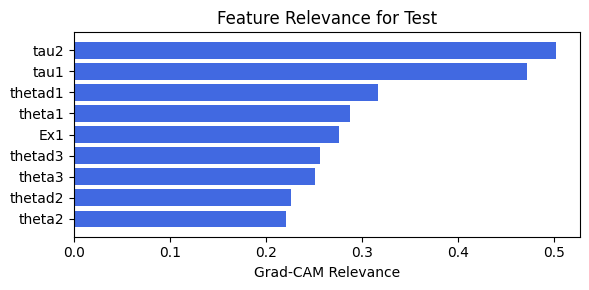

In [126]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, lamb=0.01, steps=25, alpha=0.1, filename=filename_2, opt_col_val=0.1)

# Option3

In [44]:
create_csv_with_header(filename_3, columns_opt3)

In [45]:
print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=85, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=3, kan_grid=5, lamb=0.0001 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=85, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=85, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=85, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 70/70 [01:17<00:00,  1.11s/it]


saving model version 0.1
Best epoch 3
3.740359306335449
M_KAN Relevance: 0.0
CNN Relevance: 1.0
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.02e+00 | eval_loss: 3.16e+00 | reg: 1.83e+02 |: 100%|█| 70/70 [01:12<00:00,  1.03s/i


saving model version 0.1
Best epoch 41
3.2809054851531982
M_KAN Relevance: 0.011665304191410542
CNN Relevance: 0.9883346557617188
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.06e+00 | eval_loss: 3.13e+00 | reg: 2.16e+02 |: 100%|█| 70/70 [01:12<00:00,  1.04s/i


saving model version 0.1
Best epoch 68
3.2898330688476562
M_KAN Relevance: 0.006736446171998978
CNN Relevance: 0.9932635426521301
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.03e+00 | eval_loss: 3.16e+00 | reg: 1.97e+02 |: 100%|█| 70/70 [01:12<00:00,  1.03s/i


saving model version 0.1
Best epoch 37
3.288928508758545
M_KAN Relevance: 0.012591619044542313
CNN Relevance: 0.9874083995819092
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 2.99e+00 | eval_loss: 3.19e+00 | reg: 2.72e+02 |: 100%|█| 70/70 [01:12<00:00,  1.03s/i


saving model version 0.1
Best epoch 33
3.294102430343628
M_KAN Relevance: 0.007111429702490568
CNN Relevance: 0.9928885102272034
------------------------------ kan_neurons=3, kan_grid=5, lamb=0.0001 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.04e+00 | eval_loss: 3.17e+00 | reg: 1.76e+02 |: 100%|█| 70/70 [01:19<00:00,  1.14s/i


saving model version 0.1
Best epoch 50
3.2777206897735596
M_KAN Relevance: 0.0005194958066567779
CNN Relevance: 0.9994805455207825
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.02e+00 | eval_loss: 3.16e+00 | reg: 2.21e+02 |: 100%|█| 70/70 [01:19<00:00,  1.13s/i


saving model version 0.1
Best epoch 33
3.2967441082000732
M_KAN Relevance: 0.0017923553241416812
CNN Relevance: 0.998207688331604
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 70/70 [01:22<00:00,  1.18s/it]


saving model version 0.1
Best epoch 3
3.731451988220215
M_KAN Relevance: 0.0
CNN Relevance: 1.0
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 70/70 [01:22<00:00,  1.18s/it]


saving model version 0.1
Best epoch 3
3.7570319175720215
M_KAN Relevance: 0.0
CNN Relevance: 1.0
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 2.94e+00 | eval_loss: 3.24e+00 | reg: 2.53e+02 |: 100%|█| 70/70 [01:18<00:00,  1.12s/i


saving model version 0.1
Best epoch 21
3.288412570953369
M_KAN Relevance: 0.00168776570353657
CNN Relevance: 0.9983122944831848
------------------------------ kan_neurons=2, kan_grid=3, lamb=0.01 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 70/70 [01:10<00:00,  1.00s/it]


saving model version 0.1
Best epoch 3
3.7405452728271484
M_KAN Relevance: 0.0
CNN Relevance: 1.0
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 2.94e+00 | eval_loss: 3.66e+00 | reg: 6.70e+01 |: 100%|█| 70/70 [01:04<00:00,  1.09it/


saving model version 0.1
Best epoch 42
3.5859758853912354
M_KAN Relevance: 0.03863239660859108
CNN Relevance: 0.9613676071166992
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.28e+00 | eval_loss: 3.29e+00 | reg: 7.62e+01 |: 100%|█| 70/70 [01:06<00:00,  1.04it/


saving model version 0.1
Best epoch 69
3.3878328800201416
M_KAN Relevance: 0.2464149296283722
CNN Relevance: 0.7535850405693054
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.12e+00 | eval_loss: 3.15e+00 | reg: 4.94e+01 |: 100%|█| 70/70 [01:05<00:00,  1.08it/


saving model version 0.1
Best epoch 21
3.2681679725646973
M_KAN Relevance: 0.2686379551887512
CNN Relevance: 0.7313620448112488
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.09e+00 | eval_loss: 3.28e+00 | reg: 6.13e+01 |: 100%|█| 70/70 [01:05<00:00,  1.06it/


saving model version 0.1
Best epoch 55
3.415929079055786
M_KAN Relevance: 0.0012923479080200195
CNN Relevance: 0.99870765209198
------------------------------ kan_neurons=3, kan_grid=3, lamb=0.0001 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.04e+00 | eval_loss: 3.18e+00 | reg: 1.37e+02 |: 100%|█| 70/70 [01:07<00:00,  1.03it/


saving model version 0.1
Best epoch 28
3.2699756622314453
M_KAN Relevance: 0.0042305560782551765
CNN Relevance: 0.9957695007324219
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.05e+00 | eval_loss: 3.15e+00 | reg: 1.43e+02 |: 100%|█| 70/70 [01:08<00:00,  1.03it/


saving model version 0.1
Best epoch 59
3.276284694671631
M_KAN Relevance: 0.01040694396942854
CNN Relevance: 0.9895930290222168
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.03e+00 | eval_loss: 3.22e+00 | reg: 1.82e+02 |: 100%|█| 70/70 [01:07<00:00,  1.04it/


saving model version 0.1
Best epoch 49
3.2926676273345947
M_KAN Relevance: 0.0031505257356911898
CNN Relevance: 0.9968494772911072
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.04e+00 | eval_loss: 3.15e+00 | reg: 1.81e+02 |: 100%|█| 70/70 [01:08<00:00,  1.03it/


saving model version 0.1
Best epoch 47
3.2874226570129395
M_KAN Relevance: 0.0069489916786551476
CNN Relevance: 0.9930509924888611
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.00e+00 | eval_loss: 3.21e+00 | reg: 1.99e+02 |: 100%|█| 70/70 [01:06<00:00,  1.04it/

saving model version 0.1
Best epoch 31
3.272141456604004
M_KAN Relevance: 0.004970925394445658
CNN Relevance: 0.9950290322303772


In [ ]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

In [ ]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

In [ ]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=3, lamb=0.01, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

In [ ]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=3, lamb=0.0001, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

### 3.0.0 width=[8, 2], grid=4, lamb=1e-05 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 2.56e+02 |: 100%|█| 5/5 [00:20<00:00,  4.19s/it]

saving model version 0.1
Best epoch 4
3.246669292449951
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('theta2', 0.6713456), ('theta3', 0.4206199), ('tau2', 0.32660097), ('thetad2', 0.28157446), ('tau1', 0.20760363), ('thetad3', 0.20148632), ('thetad1', 0.0793329), ('theta1', 0.04101353)]


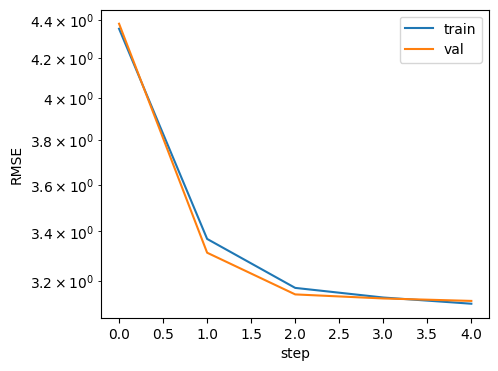

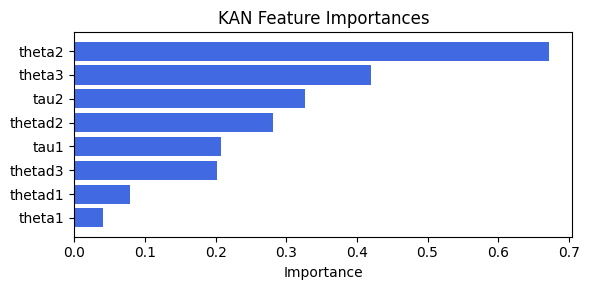

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.14it/s]


[('Ex1', 0.40617497864824975), ('tau2', 0.352492129167792), ('tau1', 0.32426184668956437), ('theta1', 0.2589648058534719), ('theta3', 0.2513404961013706), ('thetad1', 0.22948816667246685), ('thetad2', 0.21139888668402396), ('theta2', 0.1966504022716882), ('thetad3', 0.11521179873744997)]


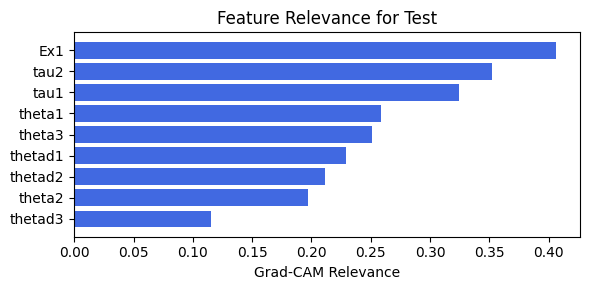

In [128]:
train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=5, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.0.1 width=[8, 2], grid=4, lamb=1e-05 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 2.28e+02 |: 100%|█| 5/5 [00:21<00:00,  4.23s/it]

saving model version 0.1
Best epoch 3
3.251054525375366
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('theta2', 0.6531223), ('theta3', 0.42788726), ('tau2', 0.33037266), ('thetad2', 0.28817976), ('tau1', 0.21687262), ('thetad3', 0.21076494), ('thetad1', 0.08280517), ('theta1', 0.042715855)]


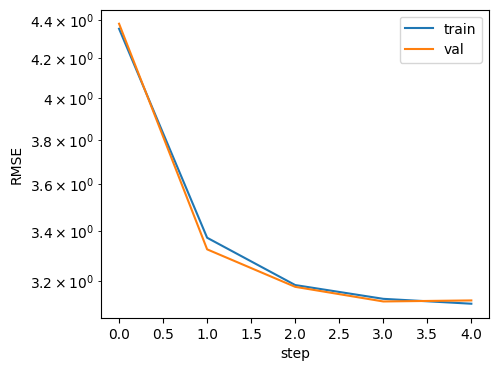

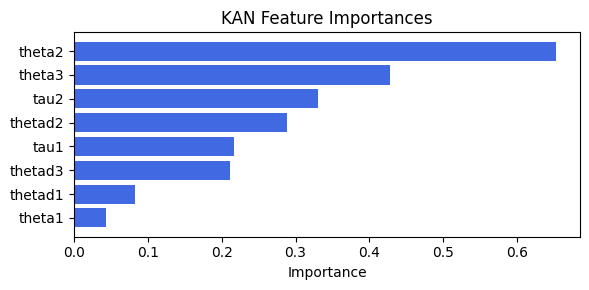

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:57<00:00, 13.96it/s]


[('Ex1', 0.38989122324147135), ('tau1', 0.35786251060053387), ('tau2', 0.35722013306796896), ('theta3', 0.3026083691839454), ('theta1', 0.22817086788719573), ('thetad1', 0.19519065413257364), ('thetad3', 0.17635604838084906), ('theta2', 0.1664376438349215), ('thetad2', 0.1467887026191153)]


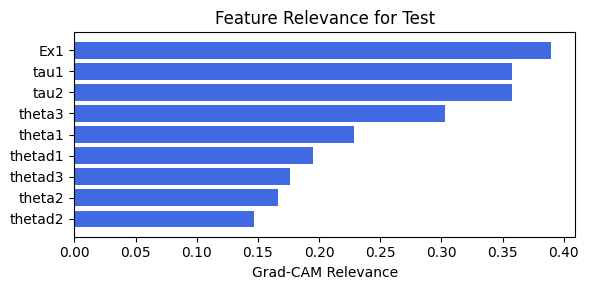

In [129]:
train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=5, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.0.2 width=[8, 2], grid=4, lamb=1e-05 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 3.04e+02 |: 100%|█| 5/5 [00:21<00:00,  4.22s/it]

saving model version 0.1
Best epoch 4
3.2523794174194336
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('tau1', 0.38878652), ('thetad2', 0.36334914), ('tau2', 0.3609325), ('thetad3', 0.36087424), ('theta2', 0.35111699), ('theta3', 0.24652748), ('thetad1', 0.1443275), ('theta1', 0.09305003)]


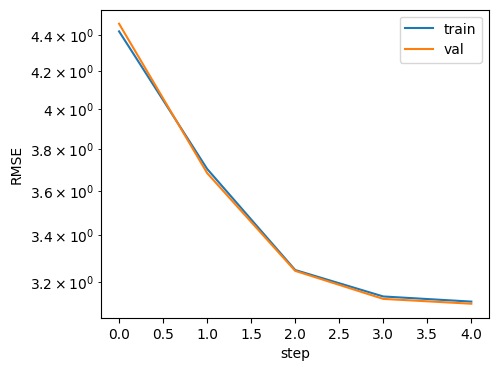

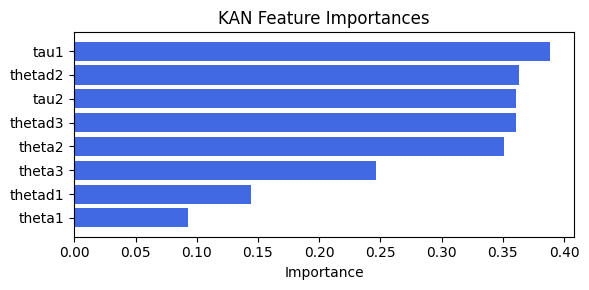

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:10<00:00, 12.60it/s]

[('tau2', 0.4096891056921542), ('thetad1', 0.35884071161264547), ('thetad2', 0.33499973878618006), ('theta1', 0.2998009041393027), ('tau1', 0.28941577901418114), ('theta2', 0.20671911226589626), ('Ex1', 0.04426729708655423), ('theta3', 0.024415129050291046), ('thetad3', 0.0002830169181625562)]


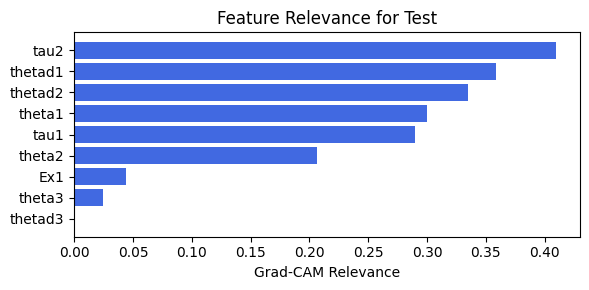

In [130]:
train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=5, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.0.3 width=[8, 2], grid=4, lamb=1e-05 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.12e+00 | eval_loss: 3.12e+00 | reg: 3.16e+02 |: 100%|█| 5/5 [00:21<00:00,  4.28s/it]

saving model version 0.1
Best epoch 3
3.2551867961883545
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('tau1', 0.38948518), ('thetad2', 0.3628481), ('thetad3', 0.36076555), ('tau2', 0.35949388), ('theta2', 0.3461855), ('theta3', 0.25438184), ('thetad1', 0.14501163), ('theta1', 0.09462738)]


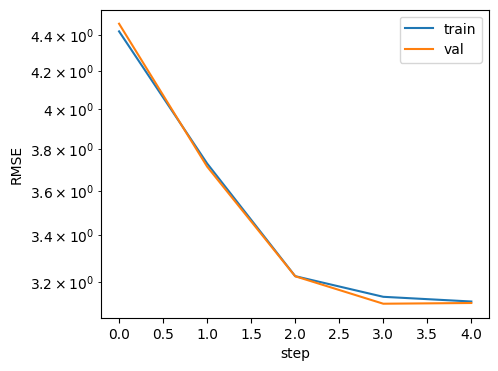

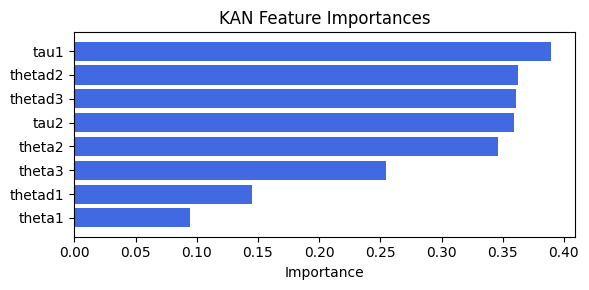

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.54it/s]

[('tau2', 0.34576353747122074), ('thetad1', 0.3149061890559083), ('thetad2', 0.26710276224820484), ('theta1', 0.25533042401559064), ('tau1', 0.2426868918373457), ('theta2', 0.17703269641891922), ('theta3', 0.021520353835199683), ('Ex1', 0.018616219550089224), ('thetad3', 0.0011873676105786015)]


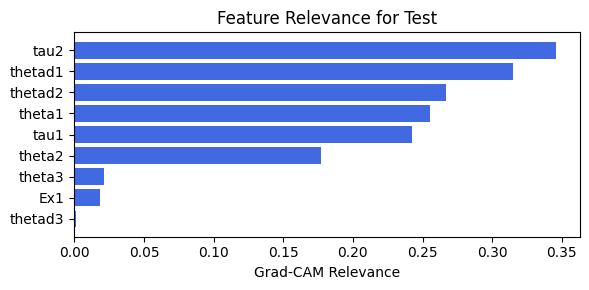

In [131]:
train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=5, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.0.4 width=[8, 2], grid=4, lamb=1e-05 | hidden_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.07e+00 | eval_loss: 3.11e+00 | reg: 1.84e+02 |: 100%|█| 27/27 [01:57<00:00,  4.35s/i

saving model version 0.1
Best epoch 23
3.277047872543335
M_KAN Relevance: 0.03818591684103012
CNN Relevance: 0.9618141055107117
[('theta3', 0.69604397), ('theta2', 0.5736312), ('thetad3', 0.09584174), ('thetad2', 0.09501882), ('thetad1', 0.092024654), ('theta1', 0.07036862), ('tau2', 0.061642356), ('tau1', 0.05393503)]


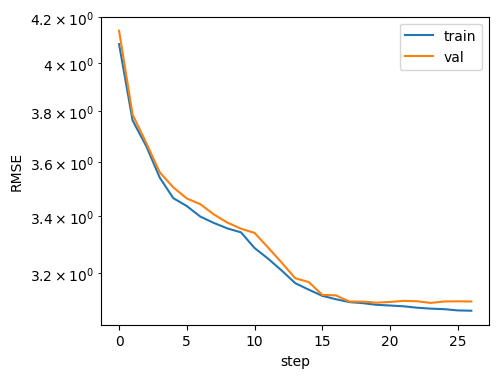

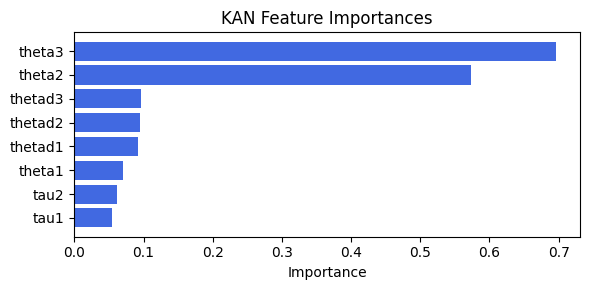

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:07<00:00, 12.82it/s]

[('thetad2', 0.16232491067230395), ('theta2', 0.13306151155500018), ('thetad1', 0.1279094983565623), ('theta1', 0.12150585906076643), ('tau1', 0.0759413106106771), ('tau2', 0.04839367557872744), ('Ex1', 0.02887773052834285), ('thetad3', 0.02426290551304326), ('theta3', 0.022467362834021686)]


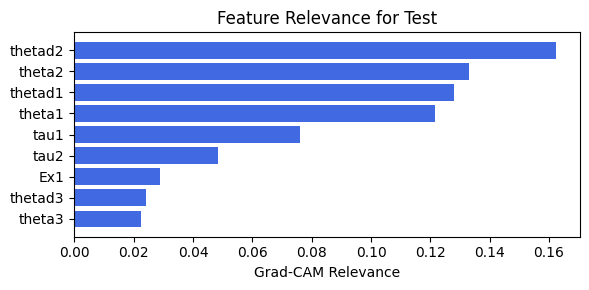

In [132]:
train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=27, hidden_dim=8, filename=filename_3, opt_col_val=8)

### 3.0.5 width=[8, 2], grid=4, lamb=1e-05 | hidden_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.08e+00 | eval_loss: 3.09e+00 | reg: 1.75e+02 |: 100%|█| 27/27 [01:56<00:00,  4.31s/i

saving model version 0.1
Best epoch 26
3.279906988143921
M_KAN Relevance: 0.04025733098387718
CNN Relevance: 0.9597426056861877
[('theta3', 0.6567637), ('theta2', 0.59861493), ('thetad3', 0.10445111), ('tau1', 0.10017617), ('thetad2', 0.09351304), ('tau2', 0.09147227), ('thetad1', 0.087904975), ('theta1', 0.08352792)]


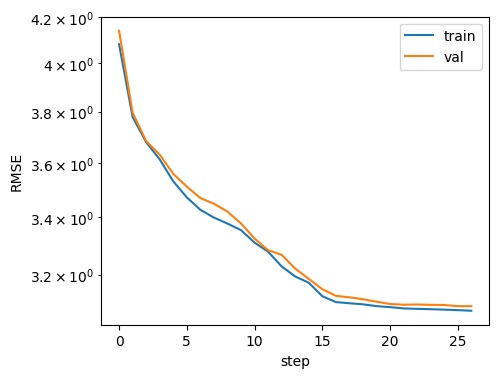

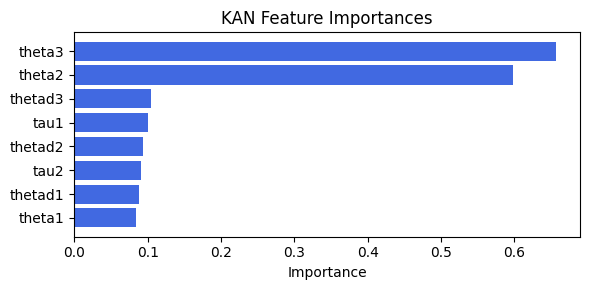

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.14it/s]


[('thetad2', 0.16550161949525938), ('theta2', 0.1372006639670308), ('thetad1', 0.12696121680329236), ('theta1', 0.11506551707190728), ('theta3', 0.09223926050798548), ('thetad3', 0.04889188473479529), ('tau2', 0.044273701158895985), ('tau1', 0.028217454021540883), ('Ex1', 0.027817924653422577)]


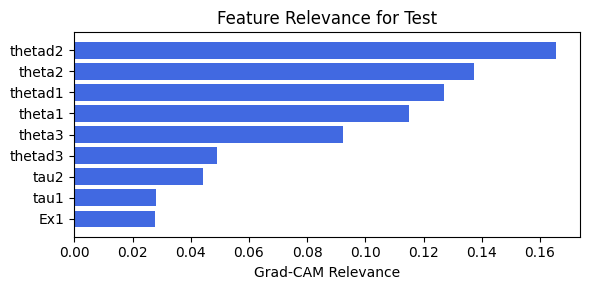

In [133]:
train_and_plot_relevance(Model3_3, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=27, hidden_dim=8, filename=filename_3, opt_col_val=8)

### 3.1.0 width=[8, 3], grid=5, lamb=0.0001 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.08e+00 | eval_loss: 3.10e+00 | reg: 9.66e+01 |: 100%|█| 30/30 [02:21<00:00,  4.73s/i

saving model version 0.1
Best epoch 24
3.3174824714660645
M_KAN Relevance: 0.10177553445100784
CNN Relevance: 0.8982244729995728
[('theta3', 0.5987778), ('theta2', 0.5365472), ('thetad2', 0.2957887), ('thetad1', 0.21993951), ('tau2', 0.1571853), ('theta1', 0.15112619), ('thetad3', 0.07778513), ('tau1', 0.061260156)]


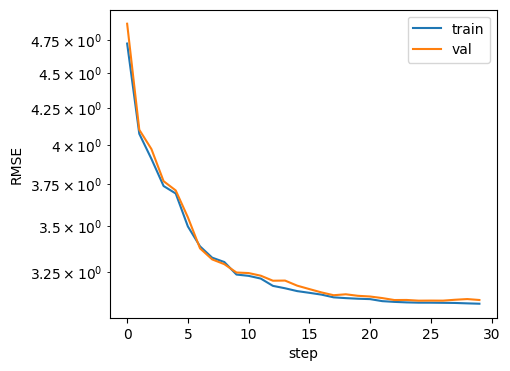

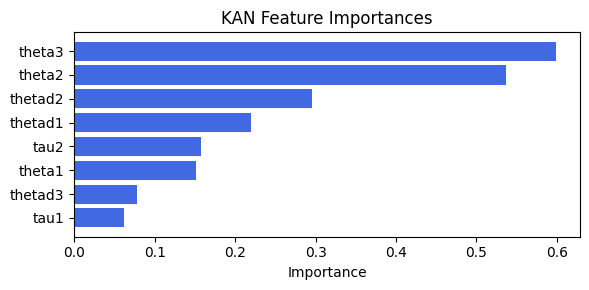

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:01<00:00, 13.51it/s]

[('thetad2', 0.15062135737851454), ('theta2', 0.1470124252093368), ('tau2', 0.133609721257374), ('thetad3', 0.13213326731472844), ('thetad1', 0.11826895420139616), ('theta1', 0.11822983306055243), ('theta3', 0.10234341843292638), ('Ex1', 0.09270860072440973), ('tau1', 0.08913587861493048)]


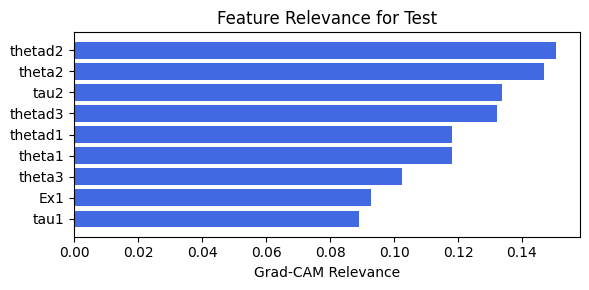

In [134]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=30, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.1.1 width=[8, 3], grid=5, lamb=0.0001 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.09e+00 | eval_loss: 3.12e+00 | reg: 1.07e+02 |: 100%|█| 30/30 [02:22<00:00,  4.76s/i

saving model version 0.1
Best epoch 28
3.3236243724823
M_KAN Relevance: 0.08526486158370972
CNN Relevance: 0.9147351384162903
[('theta3', 0.6066002), ('theta2', 0.4978133), ('thetad2', 0.3802008), ('thetad1', 0.19899622), ('theta1', 0.14164087), ('tau2', 0.09891652), ('thetad3', 0.0983223), ('tau1', 0.05862416)]


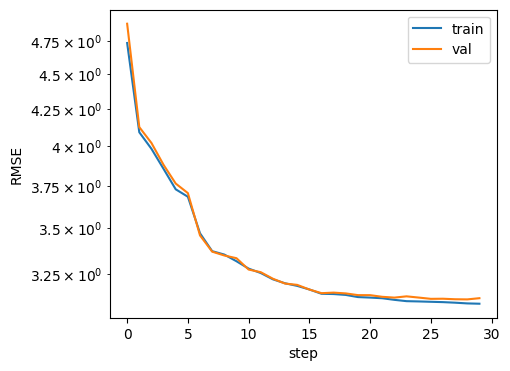

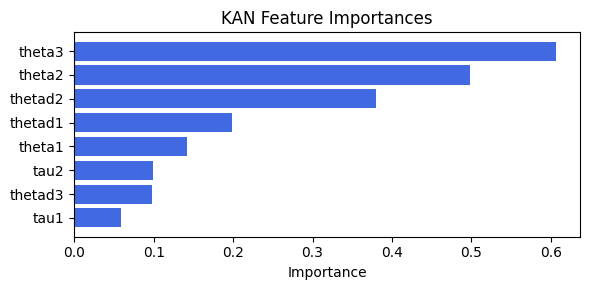

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.14it/s]


[('thetad2', 0.205202289428297), ('theta2', 0.18007497608968068), ('theta1', 0.15952130804950665), ('thetad1', 0.13225930530393118), ('thetad3', 0.09322906542057142), ('Ex1', 0.07938338248955086), ('tau2', 0.07554718718506467), ('theta3', 0.04817183858800516), ('tau1', 0.038535973410560836)]


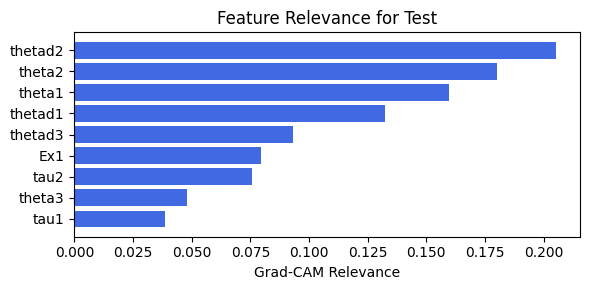

In [135]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=30, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.1.2 width=[8, 3], grid=5, lamb=0.0001 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.17e+00 | eval_loss: 3.15e+00 | reg: 1.90e+02 |: 100%|█| 4/4 [00:20<00:00,  5.07s/it]

saving model version 0.1
Best epoch 3
3.2950685024261475
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad2', 0.56187123), ('theta3', 0.36276993), ('theta2', 0.34327576), ('thetad1', 0.30366993), ('tau2', 0.27408606), ('tau1', 0.26703775), ('theta1', 0.23195347), ('thetad3', 0.03219555)]


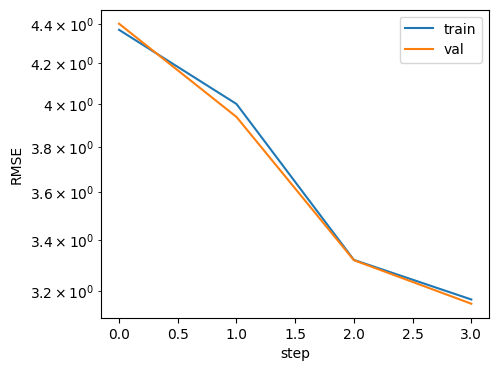

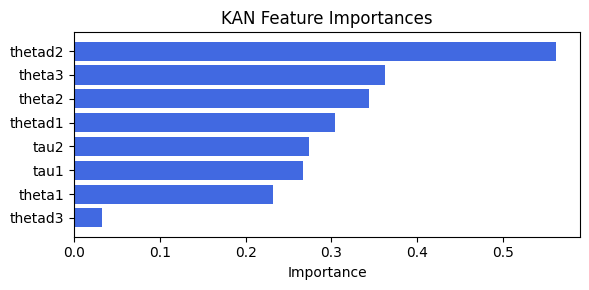

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:03<00:00, 13.32it/s]

[('tau2', 0.38253192781594475), ('tau1', 0.3436904956564356), ('thetad1', 0.33170752230817463), ('thetad2', 0.27894188393581226), ('theta1', 0.26709913152475717), ('theta2', 0.23816480403679827), ('theta3', 0.18652682575515447), ('thetad3', 0.117419441951128), ('Ex1', 0.0783195119657094)]


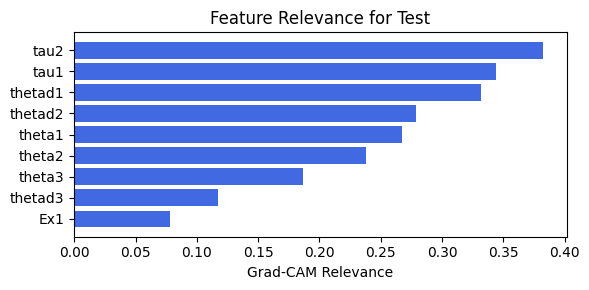

In [136]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=4, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.1.3 width=[8, 3], grid=5, lamb=0.0001 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.16e+00 | eval_loss: 3.12e+00 | reg: 2.90e+02 |: 100%|█| 4/4 [00:19<00:00,  4.90s/it]

saving model version 0.1
Best epoch 3
3.2763831615448
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad2', 0.56138), ('theta2', 0.37736702), ('theta3', 0.33139867), ('thetad1', 0.30534774), ('tau2', 0.26951712), ('tau1', 0.26691845), ('theta1', 0.23646496), ('thetad3', 0.03187529)]


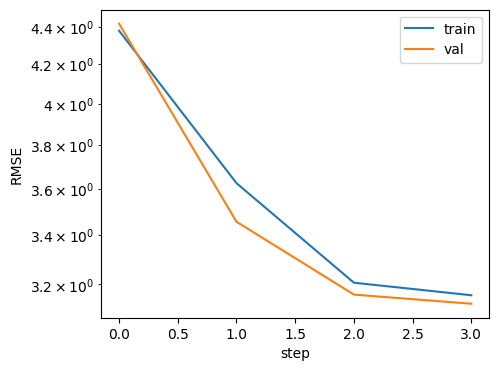

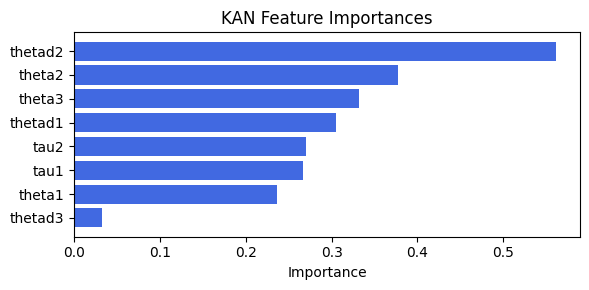

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:05<00:00, 13.06it/s]

[('thetad2', 0.4080047423741058), ('theta1', 0.40725888651534303), ('thetad1', 0.4008315632007124), ('tau2', 0.3362737580246842), ('tau1', 0.3337234947279792), ('theta2', 0.28063683550501706), ('Ex1', 0.25708340899707177), ('theta3', 0.15922647639438556), ('thetad3', 0.06823856382946805)]


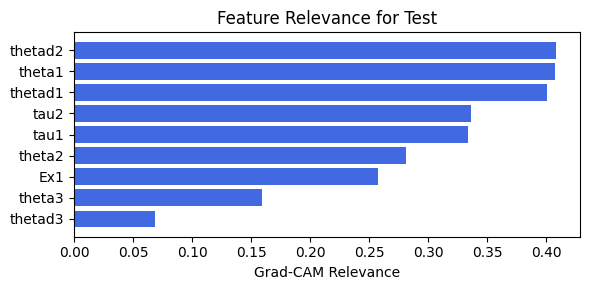

In [137]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=4, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.1.4 width=[8, 3], grid=5, lamb=0.0001 | hidden_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.13e+00 | eval_loss: 3.10e+00 | reg: 1.76e+02 |: 100%|█| 5/5 [00:23<00:00,  4.76s/it]

saving model version 0.1
Best epoch 4
3.2553842067718506
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad2', 0.5611496), ('theta2', 0.37631235), ('theta3', 0.3355901), ('thetad1', 0.300089), ('tau2', 0.27042958), ('tau1', 0.26423475), ('theta1', 0.22867708), ('thetad3', 0.03128187)]


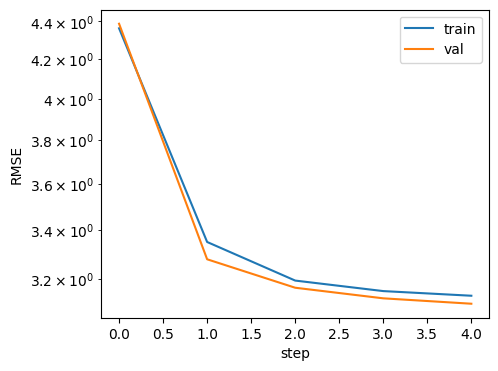

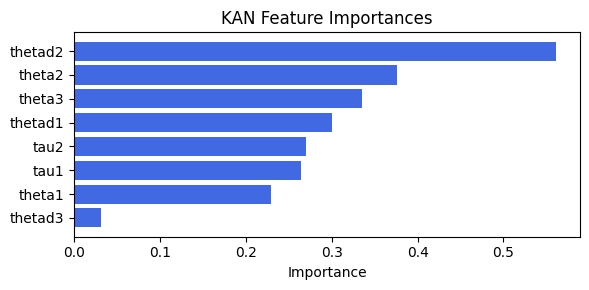

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:59<00:00, 13.67it/s]

[('theta3', 0.43768601269138424), ('thetad3', 0.2818155135126083), ('Ex1', 0.24300530063658693), ('theta2', 0.22675744975037926), ('theta1', 0.21268443683006788), ('tau1', 0.19579941932551964), ('thetad2', 0.16095028434843286), ('tau2', 0.15777301341253558), ('thetad1', 0.15210817340833996)]


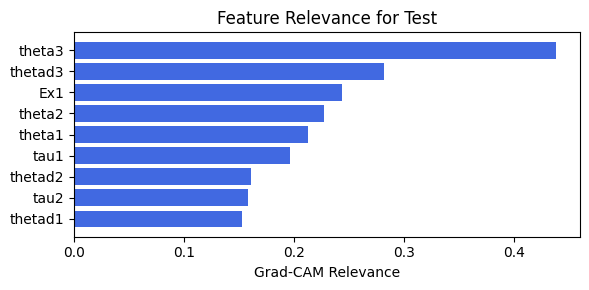

In [138]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=5, hidden_dim=8, filename=filename_3, opt_col_val=8)

### 3.1.5 width=[8, 3], grid=5, lamb=0.0001 | hidden_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.13e+00 | eval_loss: 3.10e+00 | reg: 1.66e+02 |: 100%|█| 5/5 [00:23<00:00,  4.62s/it]

saving model version 0.1
Best epoch 4
3.254180669784546
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad2', 0.5611834), ('theta2', 0.37260318), ('theta3', 0.33884388), ('thetad1', 0.30025762), ('tau2', 0.2708187), ('tau1', 0.2644115), ('theta1', 0.22864449), ('thetad3', 0.03142375)]


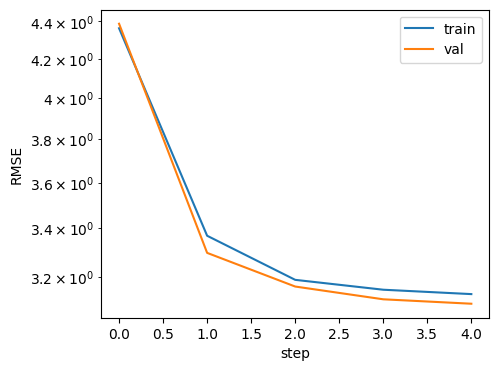

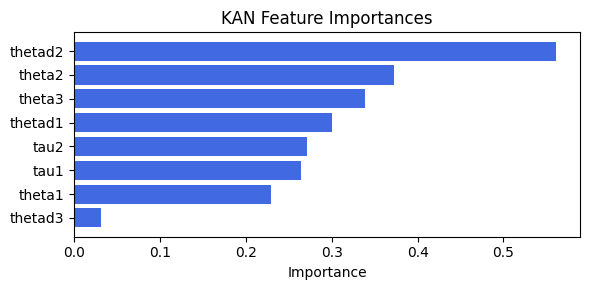

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:06<00:00, 12.94it/s]

[('theta3', 0.44899894194293566), ('thetad3', 0.27176260435294947), ('Ex1', 0.2518109152149429), ('theta2', 0.2345747348461161), ('theta1', 0.2269053152077499), ('tau1', 0.18950160415184253), ('thetad2', 0.15879155668588593), ('thetad1', 0.15573701595908246), ('tau2', 0.14308812447711786)]


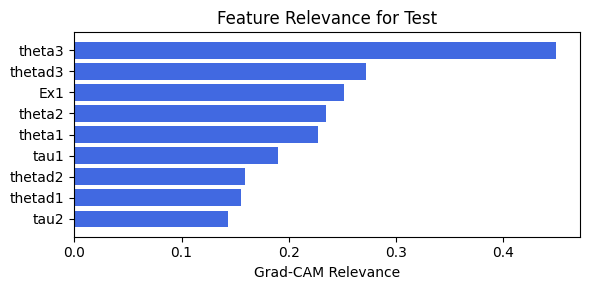

In [139]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=5, hidden_dim=8, filename=filename_3, opt_col_val=8)

### 3.2.0 width=[8, 4], grid=3, lamb=0.01 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 40/40 [02:42<00:00,  4.06s/it]

saving model version 0.1
Best epoch 4
3.251739263534546
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('theta2', 0.401448), ('thetad2', 0.3935411), ('thetad1', 0.36943585), ('theta3', 0.31888264), ('thetad3', 0.2970466), ('theta1', 0.28125656), ('tau1', 0.23055187), ('tau2', 0.09635257)]


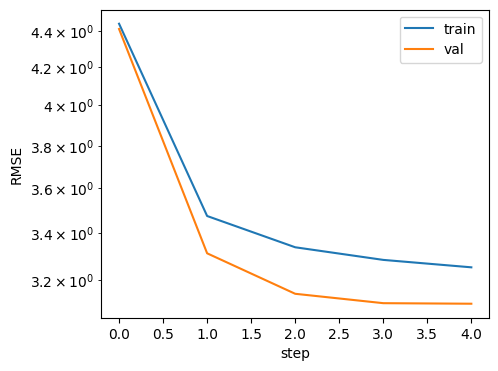

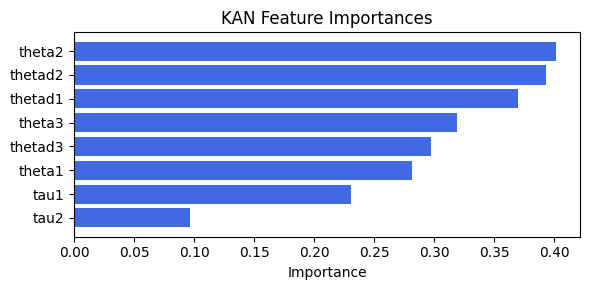

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:19<00:00, 11.71it/s]

[('thetad2', 0.38683542461816434), ('theta1', 0.37335448339657845), ('theta2', 0.3487778590483744), ('thetad1', 0.3359875945932865), ('theta3', 0.27387927353043734), ('tau1', 0.23127723906132452), ('tau2', 0.2171122347722439), ('thetad3', 0.18179196862825217), ('Ex1', 0.16607715968774595)]


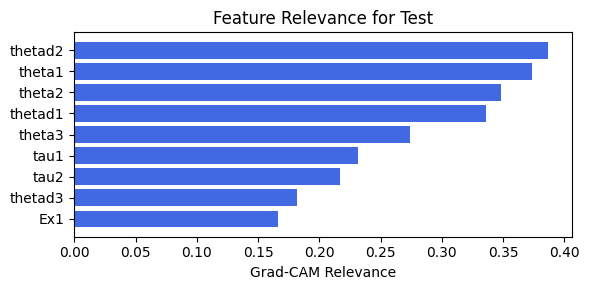

In [140]:
train_and_plot_relevance(Model3_3, kan_neurons=4, kan_grid=3, lamb=0.01, steps=40, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.2.1 width=[8, 4], grid=3, lamb=0.01 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 40/40 [02:43<00:00,  4.09s/it]

saving model version 0.1
Best epoch 4
3.2563629150390625
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad2', 0.4309251), ('thetad3', 0.4256296), ('tau1', 0.39312387), ('thetad1', 0.3148385), ('theta2', 0.21296877), ('theta3', 0.21072385), ('theta1', 0.14027573), ('tau2', 0.11947002)]


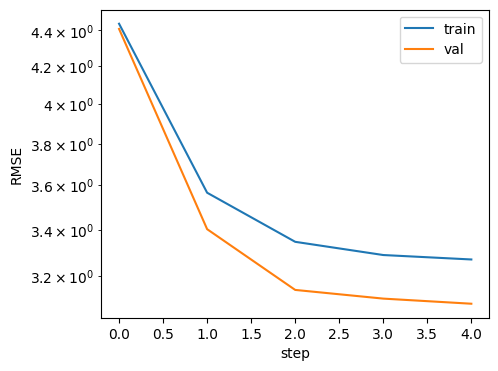

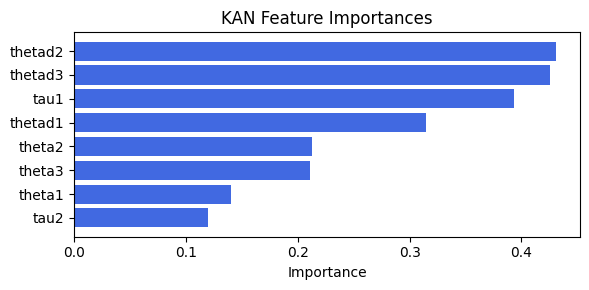

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:14<00:00, 12.23it/s]

[('thetad2', 0.36463643875823276), ('theta3', 0.3479597906528882), ('theta2', 0.3399376849717187), ('thetad3', 0.3273879314193038), ('theta1', 0.3032830909155994), ('thetad1', 0.2553484780415455), ('Ex1', 0.24534947460302), ('tau2', 0.19865061530335595), ('tau1', 0.1757151279863765)]


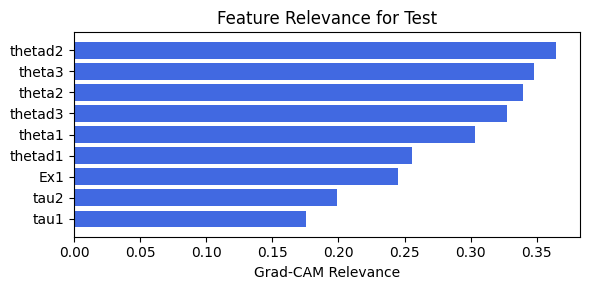

In [141]:
train_and_plot_relevance(Model3_3, kan_neurons=4, kan_grid=3, lamb=0.01, steps=40, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.2.2 width=[8, 4], grid=3, lamb=0.01 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.20e+00 | eval_loss: 3.09e+00 | reg: 5.85e+01 |: 100%|█| 5/5 [00:19<00:00,  3.93s/it]

saving model version 0.1
Best epoch 4
3.234037160873413
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('theta2', 0.574851), ('thetad3', 0.42410475), ('tau2', 0.3180675), ('tau1', 0.24718356), ('theta3', 0.22827388), ('thetad1', 0.1977629), ('theta1', 0.1738514), ('thetad2', 0.16843668)]


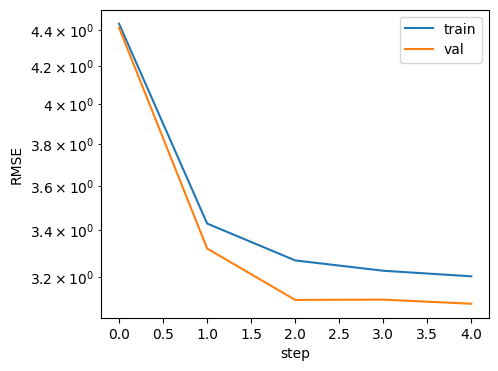

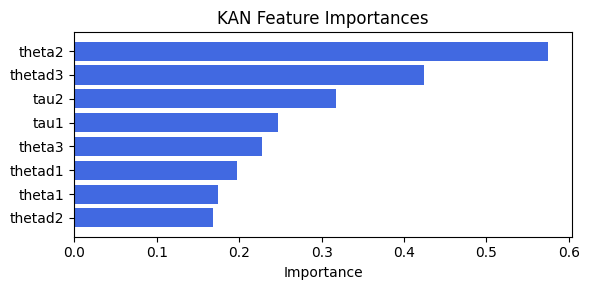

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:19<00:00, 11.75it/s]


[('theta1', 0.3890621475315675), ('thetad1', 0.3745720338757798), ('thetad2', 0.3623014465045698), ('tau1', 0.33829573804712193), ('theta2', 0.3054734400928542), ('tau2', 0.30090508922220865), ('theta3', 0.228299743736785), ('thetad3', 0.16524926005849017), ('Ex1', 0.1373904386718966)]


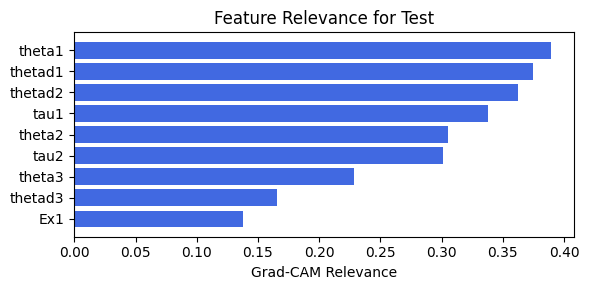

In [142]:
train_and_plot_relevance(Model3_3, kan_neurons=4, kan_grid=3, lamb=0.01, steps=5, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.2.3 width=[8, 4], grid=3, lamb=0.01 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.19e+00 | eval_loss: 3.10e+00 | reg: 5.11e+01 |: 100%|█| 5/5 [00:19<00:00,  3.97s/it]


saving model version 0.1
Best epoch 4
3.2363686561584473
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('theta3', 0.40029663), ('theta1', 0.37623262), ('tau1', 0.3041425), ('theta2', 0.2640175), ('thetad3', 0.20665042), ('tau2', 0.16672988), ('thetad1', 0.15857543), ('thetad2', 0.14045413)]


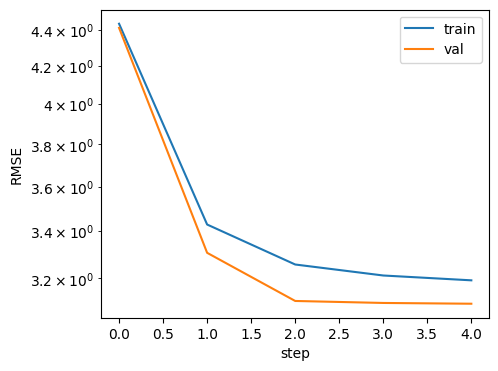

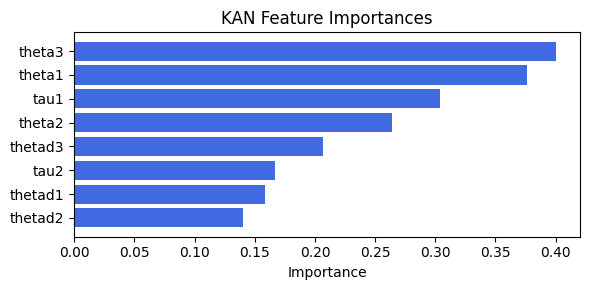

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.88it/s]

[('theta1', 0.3834911432599896), ('thetad1', 0.37884079985229796), ('thetad2', 0.34509037082844274), ('tau1', 0.3332357197940237), ('tau2', 0.29803868005262474), ('theta2', 0.2957268722218796), ('theta3', 0.2113407162673214), ('thetad3', 0.14797307429181564), ('Ex1', 0.12935844467760502)]


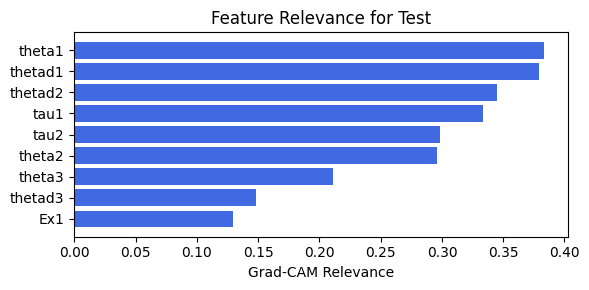

In [143]:
train_and_plot_relevance(Model3_3, kan_neurons=4, kan_grid=3, lamb=0.01, steps=5, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.2.4 width=[8, 4], grid=3, lamb=0.01 | hidden_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.09e+00 | eval_loss: 3.19e+00 | reg: 4.79e+01 |: 100%|█| 40/40 [02:27<00:00,  3.69s/i

saving model version 0.1
Best epoch 9
3.245450496673584
M_KAN Relevance: 1.7460251910961233e-05
CNN Relevance: 0.9999825358390808
[('thetad3', 0.66732866), ('theta3', 0.38966957), ('theta1', 0.24052876), ('thetad2', 0.18429118), ('thetad1', 0.17343447), ('tau1', 0.154118), ('tau2', 0.1518689), ('theta2', 0.1504082)]


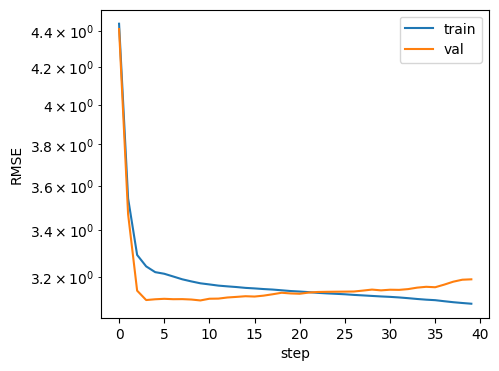

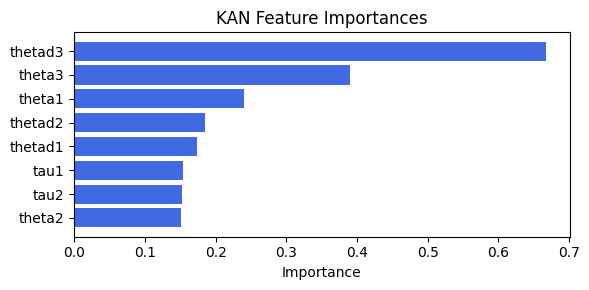

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:16<00:00, 11.97it/s]

[('thetad2', 0.4335462231975615), ('theta1', 0.36912213940181343), ('theta2', 0.36861615552117477), ('thetad1', 0.3502904063871877), ('tau2', 0.3138583127304879), ('theta3', 0.2966937425320407), ('tau1', 0.2788220226807722), ('thetad3', 0.24493098896547152), ('Ex1', 0.17591317144152666)]


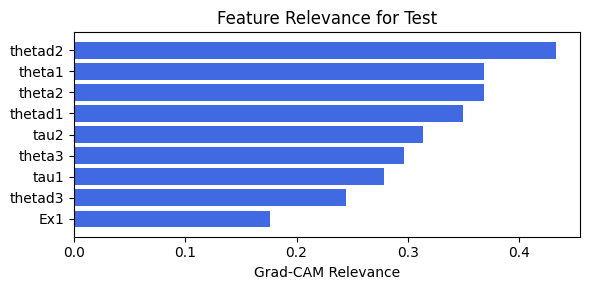

In [144]:
train_and_plot_relevance(Model3_3, kan_neurons=4, kan_grid=3, lamb=0.01, steps=40, hidden_dim=8, filename=filename_3, opt_col_val=8)

### 3.2.5 width=[8, 4], grid=3, lamb=0.01 | hidden_dim=8

### 3.3.0 width=[8, 3], grid=5, lamb=0.01 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.14e+00 | eval_loss: 3.12e+00 | reg: 5.15e+01 |: 100%|█| 30/30 [02:18<00:00,  4.62s/i

saving model version 0.1
Best epoch 24
3.3213412761688232
M_KAN Relevance: 0.2366873174905777
CNN Relevance: 0.7633126378059387
[('theta3', 0.6810896), ('theta2', 0.4270773), ('thetad1', 0.24237403), ('thetad2', 0.20454453), ('thetad3', 0.19919536), ('theta1', 0.14890641), ('tau1', 0.092884384), ('tau2', 0.049987197)]


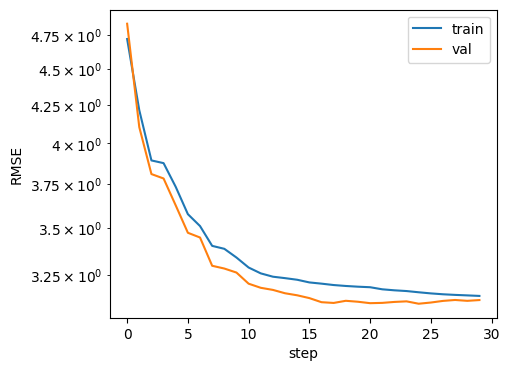

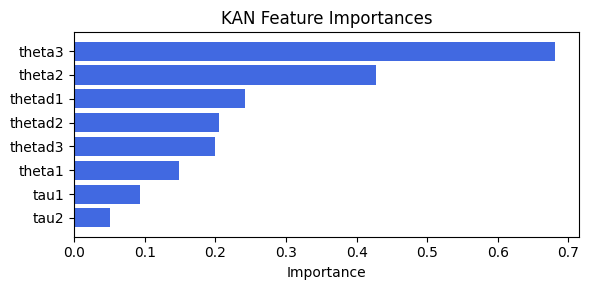

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:05<00:00, 13.04it/s]

[('thetad2', 0.19767400473588065), ('theta1', 0.1679971170961991), ('theta2', 0.15660627322051138), ('thetad1', 0.1498666349357311), ('tau2', 0.11870617428162263), ('thetad3', 0.11043603161532861), ('Ex1', 0.0812972949006918), ('tau1', 0.0713696067479544), ('theta3', 0.06174385875223836)]


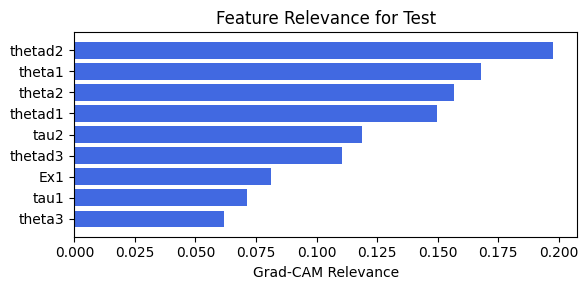

In [146]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=30, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.3.1 width=[8, 3], grid=5, lamb=0.01 | hidden_dim=128

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.13e+00 | eval_loss: 3.09e+00 | reg: 4.55e+01 |: 100%|█| 30/30 [02:18<00:00,  4.62s/i

saving model version 0.1
Best epoch 25
3.300379991531372
M_KAN Relevance: 0.2130807489156723
CNN Relevance: 0.7869192957878113
[('theta3', 0.6739423), ('theta2', 0.36748058), ('thetad2', 0.25320622), ('thetad1', 0.24581556), ('thetad3', 0.22387575), ('theta1', 0.16228187), ('tau1', 0.124899745), ('tau2', 0.11408825)]


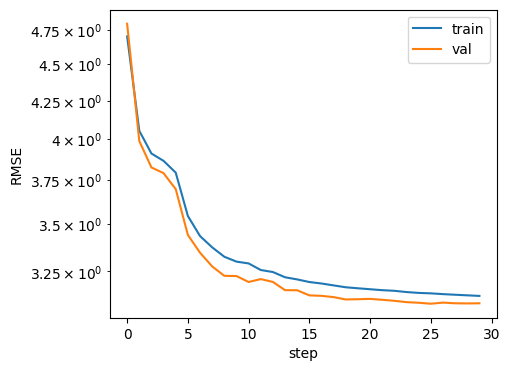

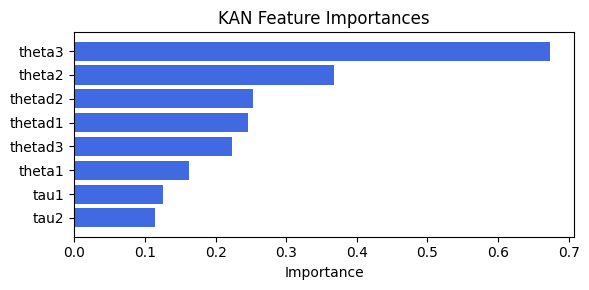

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:04<00:00, 13.18it/s]

[('thetad3', 0.5986395435140478), ('tau2', 0.4539266450524984), ('theta3', 0.3865890174420956), ('tau1', 0.2983639113121107), ('theta2', 0.1860795741318351), ('thetad1', 0.1567920652554251), ('theta1', 0.15347230810555879), ('thetad2', 0.13103914270434872), ('Ex1', 0.11410857846001739)]


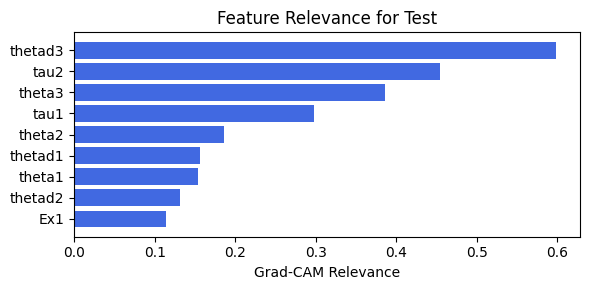

In [147]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=30, hidden_dim=128, filename=filename_3, opt_col_val=128)

### 3.3.2 width=[8, 3], grid=5, lamb=0.01 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.14e+00 | eval_loss: 3.13e+00 | reg: 5.21e+01 |: 100%|█| 30/30 [02:13<00:00,  4.44s/i

saving model version 0.1
Best epoch 14
3.236015796661377
M_KAN Relevance: 0.0001050490973284468
CNN Relevance: 0.999894917011261
[('tau2', 0.5116502), ('theta1', 0.4685871), ('theta3', 0.3938299), ('theta2', 0.29183716), ('thetad3', 0.27802414), ('thetad2', 0.15330422), ('thetad1', 0.13974331), ('tau1', 0.08864533)]


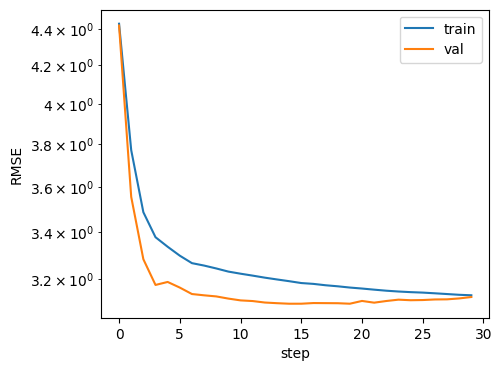

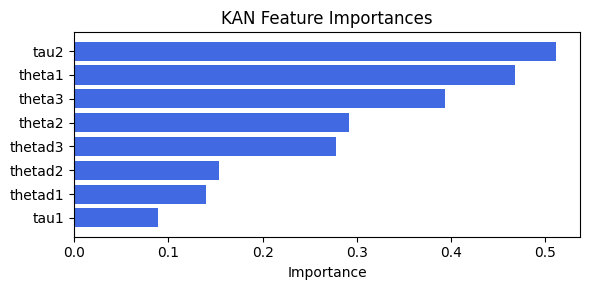

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:06<00:00, 12.97it/s]

[('tau2', 0.36803145519217056), ('tau1', 0.36283314540134737), ('theta1', 0.35040699416725574), ('thetad1', 0.33482765293138683), ('thetad2', 0.28928131563066917), ('theta2', 0.2812661969009801), ('Ex1', 0.24969002362960055), ('theta3', 0.22705570099620603), ('thetad3', 0.16420313062854575)]


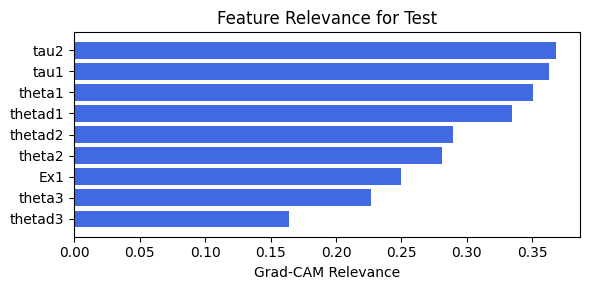

In [148]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=30, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.3.3 width=[8, 3], grid=5, lamb=0.01 | hidden_dim=32

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.15e+00 | eval_loss: 3.11e+00 | reg: 5.26e+01 |: 100%|█| 30/30 [02:11<00:00,  4.40s/i

saving model version 0.1
Best epoch 21
3.229921579360962
M_KAN Relevance: 2.9436490876832977e-05
CNN Relevance: 0.999970555305481
[('tau2', 0.6742425), ('theta1', 0.47456262), ('thetad2', 0.23265311), ('tau1', 0.22089443), ('theta2', 0.15663645), ('thetad1', 0.105379395), ('thetad3', 0.09693246), ('theta3', 0.082484394)]


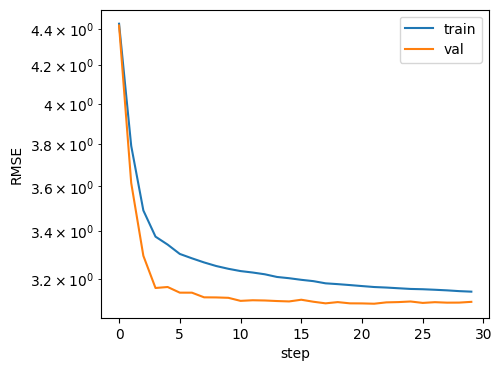

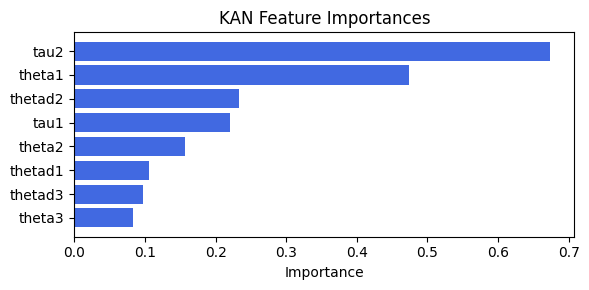

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:11<00:00, 12.49it/s]

[('tau2', 0.36941435078985135), ('theta1', 0.3566868046578867), ('thetad1', 0.3451048592912389), ('tau1', 0.34002859374113914), ('thetad2', 0.3304903986270262), ('theta2', 0.3144885172964175), ('theta3', 0.23263270843483835), ('Ex1', 0.22323856386533628), ('thetad3', 0.16729716198488187)]


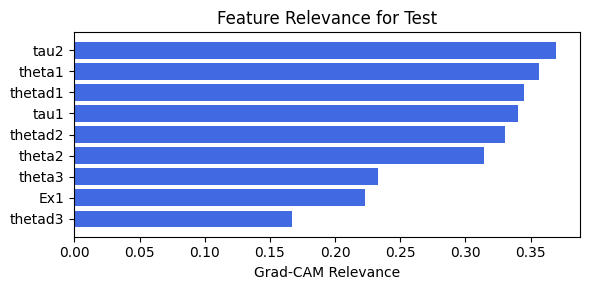

In [149]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=30, hidden_dim=32, filename=filename_3, opt_col_val=32)

### 3.3.4 width=[8, 3], grid=5, lamb=0.01 | hidden_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.30e+00 | eval_loss: 3.13e+00 | reg: 9.52e+01 |: 100%|█| 5/5 [00:22<00:00,  4.58s/it]

saving model version 0.1
Best epoch 4
3.2851507663726807
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('tau2', 0.39597934), ('thetad1', 0.38120526), ('tau1', 0.34605014), ('theta2', 0.33152997), ('thetad2', 0.328989), ('thetad3', 0.3106376), ('theta3', 0.28034598), ('theta1', 0.16354744)]


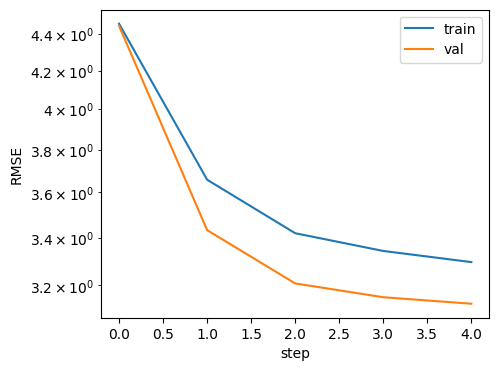

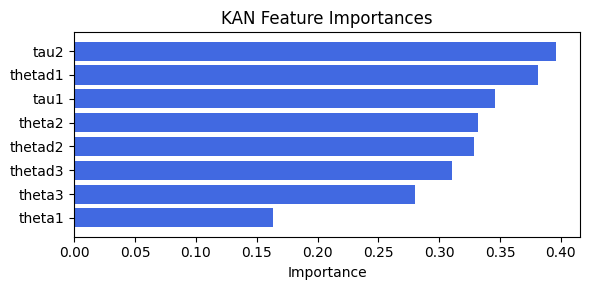

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:08<00:00, 12.80it/s]

[('theta3', 0.34845422841153234), ('thetad3', 0.3173118621802767), ('Ex1', 0.2816440408766415), ('theta2', 0.21148800393786144), ('theta1', 0.20805372182350002), ('tau1', 0.2045459495511184), ('thetad2', 0.15804809593269936), ('thetad1', 0.15442147988513885), ('tau2', 0.14968227105664633)]


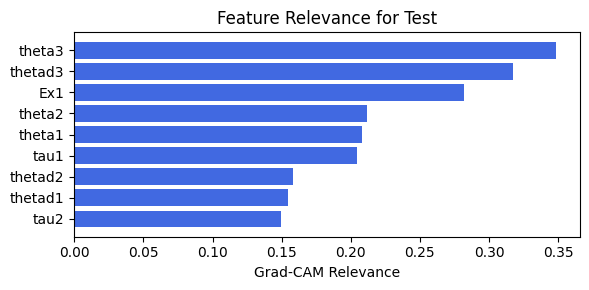

In [150]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=5, hidden_dim=8, filename=filename_3, opt_col_val=8)

### 3.3.5 width=[8, 3], grid=5, lamb=0.01 | hidden_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


| train_loss: 3.29e+00 | eval_loss: 3.13e+00 | reg: 9.59e+01 |: 100%|█| 5/5 [00:23<00:00,  4.63s/it]

saving model version 0.1
Best epoch 4
3.283827781677246
M_KAN Relevance: 0.0
CNN Relevance: 1.0
[('thetad1', 0.40900397), ('theta1', 0.40541574), ('thetad2', 0.3930657), ('theta2', 0.34506854), ('thetad3', 0.2531985), ('tau2', 0.18114123), ('tau1', 0.13337237), ('theta3', 0.106063366)]


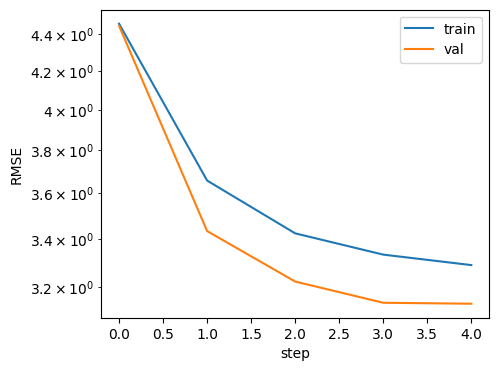

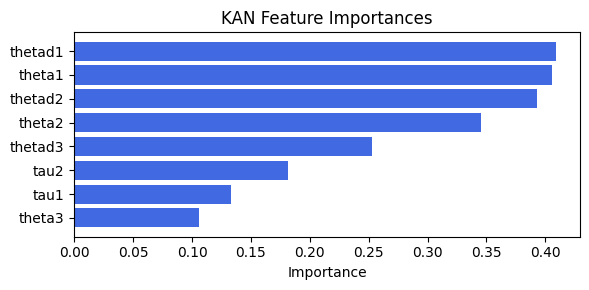

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.35it/s]

[('theta3', 0.3220084780261549), ('thetad3', 0.2857014104325231), ('Ex1', 0.2409397129218314), ('theta1', 0.21860007642473697), ('theta2', 0.21584237647807555), ('tau1', 0.2133138193735396), ('thetad1', 0.16566002750275632), ('thetad2', 0.16449162615775123), ('tau2', 0.1601002946570909)]


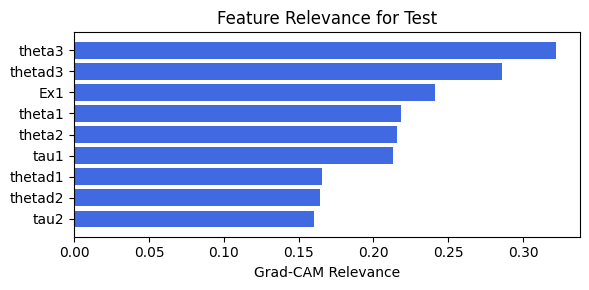

In [151]:
train_and_plot_relevance(Model3_3, kan_neurons=3, kan_grid=5, lamb=0.01, steps=5, hidden_dim=8, filename=filename_3, opt_col_val=8)

# Opt4: MultiHead Attention

In [46]:
create_csv_with_header(filename_4, columns_opt4)

In [ ]:
print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=90, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=90, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

print("------------------------------ kan_neurons=1, kan_grid=6, lamb=1e-06 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=80, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=1, kan_grid=6, lamb=1e-06, steps=80, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')


print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=80, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')
for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=80, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')



print("------------------------------ kan_neurons=7, kan_grid=4, lamb=1e-06 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=80,
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=7, kan_grid=4, lamb=1e-06, steps=80,
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


| train_loss: 3.18e+00 | eval_loss: 3.16e+00 | reg: 2.04e+01 |: 100%|█| 60/60 [00:29<00:00,  2.06it/

saving model version 0.1
Best epoch 59
3.31817626953125
M_KAN Relevance: 0.031924400478601456
CNN Relevance: 0.9680755734443665
[('theta2', 0.48214307), ('theta3', 0.4392534), ('tau2', 0.3528562), ('thetad2', 0.33414233), ('tau1', 0.29660207), ('thetad3', 0.28847894), ('thetad1', 0.11112942), ('theta1', 0.0603104)]


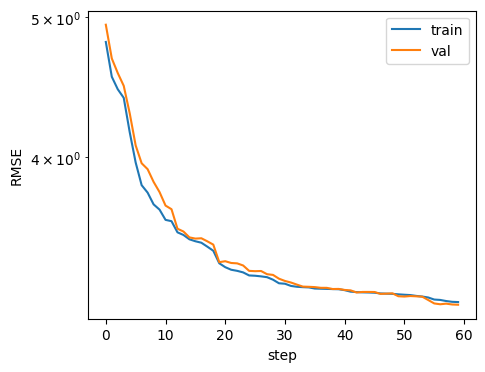

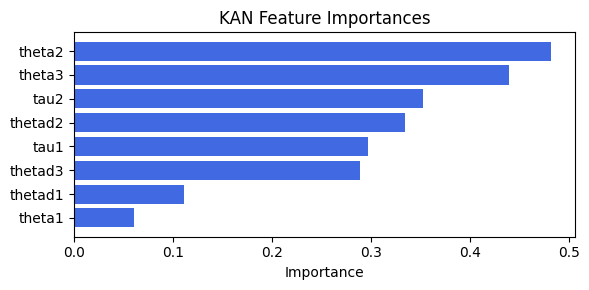

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:02<00:00, 13.40it/s]

[('tau2', 0.5827977184703871), ('tau1', 0.5622516828926304), ('Ex1', 0.39328849850685005), ('thetad2', 0.3064877969794054), ('thetad1', 0.2840933293546891), ('theta3', 0.28278605604319196), ('theta1', 0.22775555569451433), ('theta2', 0.2042660550882593), ('thetad3', 0.14868148862822558)]


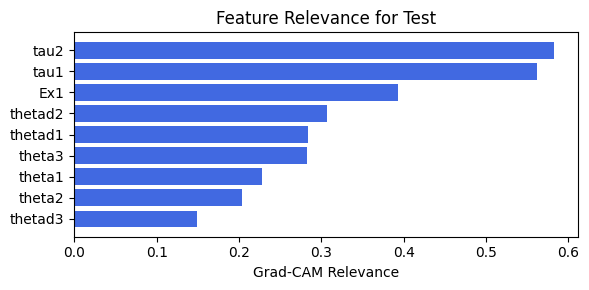

In [157]:
train_and_plot_relevance(Model3_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=60, embed_dim=16, filename=filename_4, opt_col_val=16)